In [10]:
import os
import pandas as pd
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import seaborn as sns
import math
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from abc import ABC, abstractmethod
import re
from transformers import AutoModel, AutoTokenizer
import pickle
import time
import itertools
from scipy.spatial import distance

In [11]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Dataloaders

In [12]:
class BinnedSeqDataset(Dataset):
    """
    """
    def __init__(self,sequences,text_type=1):
        """
        """
        self.sequences = sequences
        self.text_type = text_type
        pass
    
    def __len__(self):
        """
        """
        return len(self.sequences)
    
    def __gen_text_rep__(self,text_dict):
        """
        """
        if self.text_type==1:
            return text_dict["mean"]
        
        if self.text_type==2:
            return torch.concat([text_dict["cls"],text_dict["mean"]],dim=-1)
        
    
    def __getitem__(self,idx):
        """
        """
        obs_feats = self.sequences[idx] # list of timestep features
        
        keys = obs_feats.keys()
        
        res_feats = {}
        
        non_engage_rep = None
        engage_rep = None
        
        
        for k in keys:
            
            if ((k not in ["date_ranges","username"]) and ("text" not in k) and ("top" not in k)):

                if np.isscalar(obs_feats[k]):
                    res_feats[k] = torch.Tensor(np.array(obs_feats[k]).reshape(1,-1)).squeeze()
                else:
                    res_feats[k] = torch.Tensor(obs_feats[k])
            
            if "text" in k and str(self.text_type) in k:
                
                
                
                if "nengagement" in k:
                    
                    non_engage_rep = self.__gen_text_rep__(obs_feats[k])
                
                else:
                    engage_rep = self.__gen_text_rep__(obs_feats[k])
                
        
        res_feats["text_feat"] = torch.concat([engage_rep,non_engage_rep],dim=-1)
        res_feats["date_ranges"] = [(x[0].strftime('%Y-%m-%d'),x[1].strftime('%Y-%m-%d')) for x in obs_feats["date_ranges"]]
        res_feats["username"] = list(set(obs_feats["username"]))
        res_feats["hashtag_feat"] = obs_feats["tophashes"]
        res_feats["mentions_feat"] = obs_feats["topmentions"]
        
        return res_feats

# Models

## Single Feature Network

In [13]:
class LSTMForecasterSF(nn.Module):
    """
    """
    
    def __init__(self,input_size=7, hidden_dim_lstm=64,num_layers=1,bidirectional=False,output_size=7,extra_layer=0, activation="sigmoid"):
        """
        """
        super(LSTMForecasterSF, self).__init__()
        
        self.num_layers = num_layers
        self.extra_layer = extra_layer
        self.num_directions = 1
        
        if bidirectional:
            self.num_directions = 2
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_dim_lstm,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        if activation=="relu":
            self.activation = nn.ReLU()
        
        if activation=="sigmoid":
            self.activation = nn.Sigmoid()
        
        self.fc_out = nn.Linear(int(hidden_dim_lstm*self.num_directions),output_size)
        
    
    def forward(self,feats,*args):
        """
        """
        self.lstm.flatten_parameters() 
        
        batch_size = feats.shape[0]
        
        out, (ht,ct) = self.lstm(feats)
        
        ht_reshaped = torch.reshape(ht,(self.num_layers,self.num_directions,batch_size,ht.shape[-1]))
        
        ht_final_layer = ht_reshaped[-1,:,:,:]
        
        if self.num_directions>1:

            ht_forward = ht_final_layer[0,:,:]
            ht_backward = ht_final_layer[1,:,:]

            ht_final = torch.concat([ht_forward,ht_backward],dim=-1)
        
        else:
            
            ht_final = ht_final_layer[-1,:,:]
        
        
        fc_output = self.fc_out(ht_final)
        
        return ht_final,fc_output

## Multiple Feature Network

In [23]:

class LSTMForecasterMF(nn.Module):
    
    def __init__(self,
                 input_size,
                 hidden_dim_lstm=64,
                 hidden_text=128,
                 hidden_inter=128,
                 num_layers=1,
                 bidirectional=False,
                 dropout=0.1,
                 output_size=7,
                 activation="sigmoid"):
        """
        """
        super(LSTMForecasterMF, self).__init__()
        
        self.num_layers = num_layers
        
        self.num_directions = 1
        
        if bidirectional:
            self.num_directions = 2
        
        self.lstm = nn.LSTM(input_size=input_size+hidden_text+4,
                            hidden_size=hidden_dim_lstm,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        if activation=="relu":
            self.activation = nn.ReLU()
        
        if activation=="sigmoid":
            self.activation = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.fc_text = nn.Linear(3072,hidden_text)
        
        self.fc_inter = nn.Linear(int(hidden_dim_lstm*self.num_directions)+4+1536,hidden_inter)
        
        self.fc_out = nn.Linear(hidden_inter,output_size)
        
        
    def forward(self,count_feats,in_time_feats,out_time_feats,ns_feats,mention_feats,hash_feats,text_feats):
        """
        """
        self.lstm.flatten_parameters() 
        
        
        text_feats = self.fc_text(text_feats)
        
        feats = torch.concat([count_feats,text_feats,in_time_feats],dim=-1)
        
        batch_size = feats.shape[0]
        
        out, (ht,ct) = self.lstm(feats)
        
        # some matrix manipulation for cases with stacked lstm layers and bidirectional lstm
        
        ht_reshaped = torch.reshape(ht,(self.num_layers,self.num_directions,batch_size,ht.shape[-1]))
        
        ht_final_layer = ht_reshaped[-1,:,:,:]
        
        if self.num_directions>1:

            ht_forward = ht_final_layer[0,:,:]
            ht_backward = ht_final_layer[1,:,:]

            ht_final = torch.concat([ht_forward,ht_backward],dim=-1)
        
        else:
            
            ht_final = ht_final_layer[-1,:,:]
        
        
        inter_feats = torch.concat([ht_final,out_time_feats,hash_feats],dim=-1)
        
        fc_inter = self.activation(self.fc_inter(inter_feats))
        
        fc_out = self.fc_out(fc_inter)
        
        return fc_inter, fc_out

# Extra Loss Functions

In [15]:

class MAPE(nn.Module):
    
    def __init__(self,epsilon=0.0):
        """
        """
        super(MAPE, self).__init__()
        self.epsilon = epsilon
    
    def forward(self,predictions,target):
        """
        """
        abs_difference = torch.abs(predictions - target)
        abs_per_error = abs_difference/torch.clamp(torch.abs(target), min=self.epsilon)
        error_sum = torch.sum(abs_per_error)
        error_mean = error_sum/predictions.size(dim=0)
        
        return error_mean

class SMAPE(nn.Module):
    
    def __init__(self,epsilon=0.0):
        """
        """
        super(SMAPE, self).__init__()
        self.epsilon = epsilon
    
    def forward(self,predictions,target):
        """
        """
        abs_difference = torch.abs(predictions - target)
        abs_per_error = abs_difference/(torch.clamp(torch.abs(target)+torch.abs(predictions), min=self.epsilon))
        error_sum = torch.sum(abs_per_error)
        error_mean = error_sum/predictions.size(dim=0)
        
        return error_mean

class NMSE(nn.Module):
    
    def __init__(self,epsilon=0.0):
        """
        """
        super(NMSE, self).__init__()
        self.epsilon = epsilon
    
    def forward(self,predictions,target):
        """
        """
        square_difference = torch.square(predictions - target)
        nsd_per_error = square_difference
        error_sum = torch.sum(nsd_per_error)
        error_mean = error_sum/(predictions.size(dim=0)*torch.clamp(torch.var(target,dim=0),min=self.epsilon))
        
        return error_mean

# Utilities

In [24]:
class EarlyStopping(object):
    """
    """
    def __init__(self,patience,delta=0.001,verbose=False,save_path="checkpoints/checkpoint.pt"):
        """
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.verbose = verbose
        self.counter = 0
        
    
    def __call__(self,val_loss,model):
        """
        """
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        
        elif score < self.best_score + self.delta:
            self.counter+=1
            
            if self.counter >= self.patience:
                self.early_stop=True
        
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model)
            self.counter = 0
        
    
    def save_checkpoint(self,val_loss,model):
        """
        """
        if self.verbose:
            print(f'\nValidation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.save_path)
        self.val_loss_min = val_loss


def trainer(train,val,model,loss,device,lr,epochs,batch_size,patience=8,debug=True,random_seed=42,sf=1,chpath="checkpoint/checkpoint.pt"):
    """
    sf : 1 -> count features
    sf : 2 -> text features
    sf : 3 -> all features
    """
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = True
    
    early_stopping = EarlyStopping(patience=patience, verbose=False, delta=0.001,save_path=chpath)
    
    loss_map = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
    
    train_dataloader =  torch.utils.data.DataLoader(train,
                                                    num_workers=0,
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    worker_init_fn=np.random.seed(random_seed))
    
    val_dataloader =  torch.utils.data.DataLoader(val,
                                                  num_workers=0,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  worker_init_fn=np.random.seed(random_seed))
    
    print(f"Train : {len(train_dataloader)}")
    print(f"Val : {len(val_dataloader)}")
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
    
    pbar = tqdm.tqdm(range(epochs),desc="Epoch")
    
    # cosine_loss = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    for epoch in pbar:

        model.train()
        epoch_train_loss = 0.0
        batch_accuracy = 0.0

        for batch_idx,batch in enumerate(train_dataloader):
            
            
            batch["label_zscored"] = batch["label_zscored"].to(device)
            batch["eng_counts"] = batch["eng_counts"].to(device)
            batch["input_time_feat"] = batch["input_time_feat"].to(device)
            batch["output_time_feat"] = batch["output_time_feat"].to(device)
            batch["ns_feat"] =  batch["ns_feat"].to(device)
            batch["mentions_feat"] =  batch["mentions_feat"].to(device)
            batch["hashtag_feat"] =  batch["hashtag_feat"].to(device)
            batch["text_feat"] =  batch["text_feat"].to(device)
            
            
            if sf == 1:
                final_hstate,y_pred = model(batch["eng_counts"])
            
            if sf == 2:
                final_hstate,y_pred = model(batch["text_feat"])
            
            if sf == 3:
                final_hstate,y_pred = model(batch["eng_counts"],
                              batch["input_time_feat"],
                              batch["output_time_feat"],
                              batch["ns_feat"],
                              batch["mentions_feat"],
                              batch["hashtag_feat"],
                              batch["text_feat"])
            
            
            optimizer.zero_grad()
            
                
            loss1 = loss(y_pred[:,0],torch.squeeze(batch["label_zscored"])[:,0])
            loss2 = loss(y_pred[:,1],torch.squeeze(batch["label_zscored"])[:,1])
            loss3 = loss(y_pred[:,2],torch.squeeze(batch["label_zscored"])[:,2])
            loss4 = loss(y_pred[:,3],torch.squeeze(batch["label_zscored"])[:,3])
            loss5 = loss(y_pred[:,4],torch.squeeze(batch["label_zscored"])[:,4])
            loss6 = loss(y_pred[:,5],torch.squeeze(batch["label_zscored"])[:,5])
            loss7 = loss(y_pred[:,6],torch.squeeze(batch["label_zscored"])[:,6])
                
            
            # alt_loss = cosine_loss(y_pred,batch["label_zscored"]).mean()
            total_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7

            total_loss.backward()
            optimizer.step()    
                
            loss_map["train"][f"epoch_{epoch}"]["loss1"].append(loss1.item())
            loss_map["train"][f"epoch_{epoch}"]["loss2"].append(loss2.item())
            loss_map["train"][f"epoch_{epoch}"]["loss3"].append(loss3.item())
            loss_map["train"][f"epoch_{epoch}"]["loss4"].append(loss4.item())
            loss_map["train"][f"epoch_{epoch}"]["loss5"].append(loss5.item())
            loss_map["train"][f"epoch_{epoch}"]["loss6"].append(loss6.item())
            loss_map["train"][f"epoch_{epoch}"]["loss7"].append(loss7.item())
            loss_map["train"][f"epoch_{epoch}"]["total"].append(total_loss.item())
            
            
        
        loss_map["train"][f"epoch_{epoch}"]["loss1"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss1"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss2"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss2"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss3"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss3"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss4"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss4"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss5"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss5"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss6"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss6"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["loss7"] = sum(loss_map["train"][f"epoch_{epoch}"]["loss7"])/len(train_dataloader)
        loss_map["train"][f"epoch_{epoch}"]["total"] = sum(loss_map["train"][f"epoch_{epoch}"]["total"])/len(train_dataloader)
        
        
        validate(val_dataloader,model,loss,device,loss_map,epoch=epoch,valsize=len(val),sf=sf)
        
        pbar.set_postfix(train_loss=round(loss_map["train"][f"epoch_{epoch}"]["total"],5),
                         val_loss=round(loss_map["val"][f"epoch_{epoch}"]["total"],5))
        
        early_stopping(loss_map["val"][f"epoch_{epoch}"]["total"], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    if debug:
        plot_losses(loss_map)
    
    if debug:
        print(f"Train Metrics :\n")
        display(predict_and_evaluate(train_dataloader,model,device,sf=sf))

        print(f"\nVal Metrics :\n")
        display(predict_and_evaluate(val_dataloader,model,device,sf=sf))
    
    
    model.load_state_dict(torch.load(chpath))
    model.eval()
    df_scores = predict_and_evaluate(val_dataloader,model,device,sf=sf,debug=False)
    return df_scores.loc[df_scores["metric"]=="mae","avg"].item(),model





def validate(valloader,model,loss,device,loss_map,epoch,valsize,sf):
    """
    """
    model.eval()
    with torch.set_grad_enabled(False):
        for batch_idx,batch in (enumerate(valloader)):
            
            
            batch["label_zscored"] = batch["label_zscored"].to(device)
            batch["eng_counts"] = batch["eng_counts"].to(device)
            batch["input_time_feat"] = batch["input_time_feat"].to(device)
            batch["output_time_feat"] = batch["output_time_feat"].to(device)
            batch["ns_feat"] =  batch["ns_feat"].to(device)
            batch["mentions_feat"] =  batch["mentions_feat"].to(device)
            batch["hashtag_feat"] =  batch["hashtag_feat"].to(device)
            batch["text_feat"] =  batch["text_feat"].to(device)
            
            if sf == 1:
                final_hstate,y_pred = model(batch["eng_counts"])
            
            if sf == 2:
                final_hstate,y_pred = model(batch["text_feat"])
            
            if sf == 3:
                final_hstate,y_pred = model(batch["eng_counts"],
                              batch["input_time_feat"],
                              batch["output_time_feat"],
                              batch["ns_feat"],
                              batch["mentions_feat"],
                              batch["hashtag_feat"],
                              batch["text_feat"])
            
                
            loss1 = loss(y_pred[:,0],torch.squeeze(batch["label_zscored"])[:,0])
            loss2 = loss(y_pred[:,1],torch.squeeze(batch["label_zscored"])[:,1])
            loss3 = loss(y_pred[:,2],torch.squeeze(batch["label_zscored"])[:,2])
            loss4 = loss(y_pred[:,3],torch.squeeze(batch["label_zscored"])[:,3])
            loss5 = loss(y_pred[:,4],torch.squeeze(batch["label_zscored"])[:,4])
            loss6 = loss(y_pred[:,5],torch.squeeze(batch["label_zscored"])[:,5])
            loss7 = loss(y_pred[:,6],torch.squeeze(batch["label_zscored"])[:,6])
                
                
            total_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7
                
            loss_map["val"][f"epoch_{epoch}"]["loss1"].append(loss1.item())
            loss_map["val"][f"epoch_{epoch}"]["loss2"].append(loss2.item())
            loss_map["val"][f"epoch_{epoch}"]["loss3"].append(loss3.item())
            loss_map["val"][f"epoch_{epoch}"]["loss4"].append(loss4.item())
            loss_map["val"][f"epoch_{epoch}"]["loss5"].append(loss5.item())
            loss_map["val"][f"epoch_{epoch}"]["loss6"].append(loss6.item())
            loss_map["val"][f"epoch_{epoch}"]["loss7"].append(loss7.item())
            loss_map["val"][f"epoch_{epoch}"]["total"].append(total_loss.item())
            
        
        loss_map["val"][f"epoch_{epoch}"]["loss1"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss1"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss2"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss2"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss3"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss3"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss4"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss4"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss5"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss5"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss6"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss6"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["loss7"] = sum(loss_map["val"][f"epoch_{epoch}"]["loss7"])/len(valloader)
        loss_map["val"][f"epoch_{epoch}"]["total"] = sum(loss_map["val"][f"epoch_{epoch}"]["total"])/len(valloader)



        
def plot_losses(loss_map):
    """
    """
    
    fig,ax = plt.subplots(2,4,figsize=(12,6))
    
    axes = ax.ravel()
    
    keys= ["total"]+[f"loss{i}" for i in range(1,8)]
    
    ps_id_map = {k+1:v for k,v in enumerate(range(-3,4,1))}
    
    for i,k in enumerate(keys):
        train_l = [loss_map["train"][epo][k] for epo in loss_map["train"].keys()]
        val_l = [loss_map["val"][epo][k] for epo in loss_map["val"].keys()]
        
        axes[i].plot(range(len(train_l)),train_l,marker=".",markeredgecolor="tab:blue",label="Train",alpha=0.8,linestyle="--")
        axes[i].plot(range(len(val_l)),val_l,marker=".",markeredgecolor="tab:orange",label="Validation",alpha=0.8,linestyle="--")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].grid(False)
        axes[i].legend()
        if k == "total":
            axes[i].set_title("Total Loss")
        else:
            axes[i].set_title(f"Loss : {ps_id_map[int(k.replace('loss',''))]}")
        
    fig.tight_layout()
    plt.show()

def mean_absolute_percentage_error(truth,predictions,epsilon=1):
    """
    """
    abs_difference = np.abs(predictions - truth)
    abs_per_error = abs_difference/np.abs(truth)
    abs_per_error[np.isnan(abs_per_error)]=0
    abs_per_error[np.isinf(abs_per_error)]=0
    
    error_sum = np.sum(abs_per_error)
    error_mean = error_sum/predictions.shape[0]
    return error_mean

def normalized_mean_squared_error(truth,predictions,epsilon=1e-2):
    """
    """
    abs_difference = np.square(predictions - truth)
    abs_per_error = abs_difference
    error_sum = np.sum(abs_per_error)
    error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
    return error_mean

def symmetric_mean_absolute_percentage_error(truth,predictions,epsilon=0):
    """
    """
    abs_difference = np.abs(predictions - truth)
    abs_per_error = abs_difference/(np.abs(truth) + np.abs(predictions))
    error_sum = np.sum(abs_per_error)
    error_mean = error_sum/predictions.shape[0]
    return error_mean

def score_preds(preds,truths):
    """
    """
     # mae,mse,mape,nmse,
    maes = []
    mses = []
    mapes = []
    nmses = []
    smapes=[]
    
    for ind,i in enumerate(range(-3,4,1)):
        maes.append(mean_absolute_error(truths[:,ind],preds[:,ind]))
        mses.append(mean_squared_error(truths[:,ind],preds[:,ind]))
        mapes.append(mean_absolute_percentage_error(truths[:,ind],preds[:,ind],epsilon=0))
        nmses.append(normalized_mean_squared_error(truths[:,ind],preds[:,ind],epsilon=0))
        smapes.append(symmetric_mean_absolute_percentage_error(truths[:,i],preds[:,i],epsilon=0))
    
    scores = np.array([mses,maes,mapes,smapes,nmses])
    
    df = pd.DataFrame(scores,columns=[i for i in range(-3,4,1)])
    
    df["metric"] = ["mse","mae","mape","smape","nmse"]
    
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    df["avg"] = df[[i for i in range(-3,4,1)]].mean(axis=1)
    df["sum"] = df[[i for i in range(-3,4,1)]].sum(axis=1)
    
    return df

def predict_and_evaluate(dataloader,model,device,sf,debug=True):
    """
    1. display over all scores with true vs pred plot
    2. Split test into seperate sub datasets based on ranking metrics of hardness
    3. Plot comparisons of varying sub dataset size and a metric score
    """
    preds, truths,forecasts = transform_predictions(dataloader,model,device,sf)
    
    if debug :
        print(f"Overall Performance :\n")
        plot_truth_vs_pred(truths,preds)
    
    return score_preds(preds,truths)
    


def transform_predictions(dataloader,model,device,sf):
    """
    """
    model.eval()
    preds = []
    truths = []
    means = []
    std_devs = []
    forecast_quarters = []
    
    with torch.set_grad_enabled(False):
        for b_id,batch in enumerate(dataloader):
            
            forecast_quarters.append(batch["output_quarter"])
            
            batch["label_zscored"] = batch["label_zscored"].to(device)
            batch["eng_counts"] = batch["eng_counts"].to(device)
            batch["input_time_feat"] = batch["input_time_feat"].to(device)
            batch["output_time_feat"] = batch["output_time_feat"].to(device)
            batch["ns_feat"] =  batch["ns_feat"].to(device)
            batch["mentions_feat"] =  batch["mentions_feat"].to(device)
            batch["hashtag_feat"] =  batch["hashtag_feat"].to(device)
            batch["text_feat"] =  batch["text_feat"].to(device)
            
            if sf == 1:
                final_hidden_state, y_pred = model(batch["eng_counts"])
            
            if sf == 2:
                final_hidden_state, y_pred = model(batch["text_feat"])
            
            if sf == 3:
                final_hidden_state, y_pred = model(batch["eng_counts"],
                              batch["input_time_feat"],
                              batch["output_time_feat"],
                              batch["ns_feat"],
                              batch["mentions_feat"],
                              batch["hashtag_feat"],
                              batch["text_feat"])
            
            y_orig=batch["label_original"]
            mean = batch["means"] # means
            std_dev = batch["stddevs"] # std-devs
                
            preds.append(y_pred.detach().cpu().numpy())
            truths.append(y_orig.squeeze())

            means.append(mean)
            std_devs.append(std_dev)

    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    means = np.concatenate(means)
    std_devs = np.concatenate(std_devs)
    forecast_quarters = np.concatenate(forecast_quarters)

    # re-standardize
    transformed_preds = (preds*std_devs)+ means
    
    transformed_preds = np.clip(transformed_preds,a_min=0,a_max=None)
    

    return transformed_preds, truths, forecast_quarters 


def calc_quarter(truths,preds,display_=True):
    """
    """
    maes = []
    mses = []
    mapes = []
    nmses = []
    smapes=[]
    
    truths = np.array(truths)
    preds = np.array(preds)
    
    print(f"Num samples - Truth : {truths.shape}")
    print(f"Num samples - Preds : {preds.shape}")
    
    for ind,i in enumerate(range(-3,4,1)):
        maes.append(mean_absolute_error(truths[:,ind],preds[:,ind]))
        mses.append(mean_squared_error(truths[:,ind],preds[:,ind]))
        mapes.append(mean_absolute_percentage_error(truths[:,ind],preds[:,ind],epsilon=0))
        nmses.append(normalized_mean_squared_error(truths[:,ind],preds[:,ind],epsilon=0))
        smapes.append(symmetric_mean_absolute_percentage_error(truths[:,i],preds[:,i],epsilon=0))
    
    scores = np.array([mses,maes,mapes,smapes,nmses])
    
    df = pd.DataFrame(scores,columns=[i for i in range(-3,4,1)])
    
    df["metric"] = ["mse","mae","mape","smape","nmse"]
    
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    df["avg"] = df[[i for i in range(-3,4,1)]].mean(axis=1)
    df["sum"] = df[[i for i in range(-3,4,1)]].sum(axis=1)
    
    if display_:
        display(df)
    
    return df


def predict_baseline(test_dataset):
    """
    """
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=100,num_workers=0)
    
    preds = []
    truths = []
    means = []
    std_devs = []
    orig_preds = []
    
    forecast_quarters = []
    
    for b_id,batch in enumerate(test_loader):
        
        
        forecast_quarters.append(batch["output_quarter"])

        x = batch["eng_counts"] # x
        y = batch["label_zscored"] # y
        y_orig=batch["label_original"]
        mean = batch["means"] # means
        std_dev = batch["stddevs"] # std-devs
        
        if len(x.shape)>2:
            preds.append(x[:,-1,:])
        
        if len(x.shape)<=2:
            preds.append(x.reshape(x.shape[0],8,-1)[:,-1,:])
        
        truths.append(y_orig.squeeze())
        means.append(mean)
        std_devs.append(std_dev)


    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    means = np.concatenate(means)
    std_devs = np.concatenate(std_devs)
    
    forecast_quarters = np.concatenate(forecast_quarters)
    
    print(f"Num samples - Truth : {truths.shape}")
    print(f"Num samples - Preds : {preds.shape}")

    # re-standardize
    transformed_preds = (preds*std_devs)+ means

    maes = []
    mses = []
    mapes = []
    nmses = []
    smapes=[]

    plot_truth_vs_pred(truths,transformed_preds)

    for ind,i in enumerate(range(-3,4,1)):
        maes.append(mean_absolute_error(truths[:,ind],transformed_preds[:,ind]))
        mses.append(mean_squared_error(truths[:,ind],transformed_preds[:,ind]))
        mapes.append(mean_absolute_percentage_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))
        nmses.append(normalized_mean_squared_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))
        smapes.append(symmetric_mean_absolute_percentage_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))

    scores = np.array([mses,maes,mapes,smapes,nmses])

    df = pd.DataFrame(scores,columns=[i for i in range(-3,4,1)])

    df["metric"] = ["mse","mae","mape","smape","nmse"]

    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    df["avg"] = df[[i for i in range(-3,4,1)]].mean(axis=1)
    df["sum"] = df[[i for i in range(-3,4,1)]].sum(axis=1)
    display(df)
   

    preds_by_quarter = select_quarter_test(transformed_preds,forecast_quarters)
    truths_by_quarter = select_quarter_test(truths,forecast_quarters)

    preds_1 = preds_by_quarter[1]
    preds_2 = preds_by_quarter[2]
    preds_3 = preds_by_quarter[3]
    preds_4 = preds_by_quarter[4]

    truths_1 = truths_by_quarter[1]
    truths_2 = truths_by_quarter[2]
    truths_3 = truths_by_quarter[3]
    truths_4 = truths_by_quarter[4]

    print(f"Quarter 1:")
    df_q1 = calc_quarter(truths_1,preds_1)
    print(f"Quarter 2:")
    df_q2 = calc_quarter(truths_2,preds_2)
    print(f"Quarter 3:")
    df_q3 = calc_quarter(truths_3,preds_3)
    
    if len(truths_4)>0:
        print(f"Quarter 4:")
        df_q4 = calc_quarter(truths_4,preds_4)
    
def select_quarter_test(scores,forecast_quarters):
    """
    every 4 samples represents a year
    """
    quarter_map = {i:[] for i in range(1,5,1)}
    
    for idx,f in enumerate(forecast_quarters):
        quarter_map[f].append(scores[idx])
            
    return quarter_map


def plot_truth_vs_pred(truths,preds):
    """
    """
    fig,ax=plt.subplots(2,4,figsize=(13,6))
    axes = ax.ravel()
    
    def plot_identity(ax,x,y):
        """
        """
        max_val = int(max(np.max(x),np.max(y)))
        ax.plot([i for i in range(max_val+1)],[j for j in range(max_val+1)],linestyle="--",linewidth=1,color="red",alpha=0.4)
        
    
    stances = [i for i in range(-3,4,1)]
    for j in range(truths.shape[1]):
        axes[j].scatter(truths[:,j],preds[:,j],marker="o",color="tab:purple",edgecolor="black",alpha=0.7)
        axes[j].set_ylabel("Predicted Value")
        axes[j].set_xlabel("True Value")
        axes[j].set_title(f"Stance : {stances[j]}")
        plot_identity(axes[j],truths[:,j],preds[:,j])
        
    axes[-1].axis("off")
    fig.tight_layout()
    plt.show()
    
    fig,ax=plt.subplots(2,4,figsize=(13,6))
    axes = ax.ravel()
    
    for j in range(truths.shape[1]):
        axes[j].hexbin(x=truths[:,j],y=preds[:,j],gridsize = 25,alpha=1.0,bins = "log",cmap = "magma")
        axes[j].set_ylabel("Predicted Value")
        axes[j].set_xlabel("True Value")
        axes[j].set_title(f"Stance : {stances[j]}")
        plot_identity(axes[j],truths[:,j],preds[:,j])
        
    axes[-1].axis("off")
    fig.tight_layout()
    plt.show()

In [25]:
def check_empty_input_seq(count_mat):
    """
    count_mat -> 9,7
    count_mat_input -> 8,7
    
    so if entire sum of mat <=56 (since 0->1)
    then sequence is empty from engagements
    """
    assert count_mat.shape[0] == 9
    
    if np.sum(count_mat[:-1,:])<=56:
        return True
    else:
        return False
    

def filter_observations(obs_list):
    """
    remove observations where there in no engagement activity across the entire input sequence
    """
    filtered_obs = []
    for obs in tqdm.tqdm(obs_list):
        if not check_empty_input_seq(obs["original_counts"]):
            filtered_obs.append(obs)
    
    print(f"Filtered Size : {len(filtered_obs)}")
    print(f"Removed {len(obs_list) - len(filtered_obs)} empty observations")
    return filtered_obs

In [31]:
class HardnessRanker(object):
    """
    Measure Hardness based on 
    * Cosine Measure
    * Sum of Variance through time
    * no-engagement -> engagement score (count of consecutive empty bins starting from the last timestep of the input and output has to be not empty)
    *
    
    These are performed based on zscored counts
    """
    def __init__(self,test_set,last_n=3):
        """
        """
        self.data = test_set
        self.last_n = last_n
    
    def calc_cosine(self,engagement_counts):
        """
        cosine distance between last n timesteps of the input and the forecast horizon
        """
        input_ = engagement_counts[-2,:]
        out_ = engagement_counts[-1,:]
        
        return distance.cosine(input_,out_)
        
            
    def calc_variance(self,engagement_counts):
        """
        sum of variance across time 
        """
        vars_ = []
        for s in range(7):
            var_s = np.var(engagement_counts[-2:,s])
            vars_.append(var_s)
        
        return sum(vars_)
    
    def calc_no_eng_eng(self,engagement_counts):
        """
        """
        if sum(engagement_counts[-2,:])==7 and sum(engagement_counts[-1,:]) > 7:
            return True
        
        return False
    
    def calc_eng_no_eng(self,engagement_counts):
        """
        """
        if sum(engagement_counts[-1,:])==7 and sum(engagement_counts[-2,:]) > 7:
            return True
        
        return False
    
    def calc_scores(self,engagement_counts,metric):
        """
        """
        if metric == "cosine":
            return self.calc_cosine(engagement_counts)
        
        if metric == "variance":
            return self.calc_variance(engagement_counts)
    
    def run(self):
        """
        """
        result = {}
        ranked_tups_cosine = []
        ranked_tups_var = []
        filtered_tups_no_eng_eng = []
        filtered_tups_eng_no_eng = []
        for ind,obs in tqdm.tqdm(enumerate(self.data)):
            x = obs["original_counts"]
            score_cosine = self.calc_scores(x,metric= "cosine")
            score_var = self.calc_scores(x,metric="variance")
            ranked_tups_cosine.append((score_cosine,ind))
            ranked_tups_var.append((score_var,ind))
            
            if self.calc_no_eng_eng(x):
                filtered_tups_no_eng_eng.append(ind)
            
            if self.calc_eng_no_eng(x):
                filtered_tups_eng_no_eng.append(ind)
            
        ranked_tups_cosine = sorted(ranked_tups_cosine,key=lambda x: x[0],reverse=True)
        ranked_tups_var = sorted(ranked_tups_var,key=lambda x: x[0],reverse=True)
        
        result["ranked_cosine"] = ranked_tups_cosine
        result["ranked_var"] = ranked_tups_var
        result["no_eng->eng"] = filtered_tups_no_eng_eng
        result["eng->no_eng"] = filtered_tups_eng_no_eng
        
        return result



In [32]:
def score_reg_metrics(truths,transformed_preds):
    """
    """
    maes = []
    mses = []
    mapes = []
    nmses = []
    smapes=[]

    for ind,i in enumerate(range(-3,4,1)):
        maes.append(mean_absolute_error(truths[:,ind],transformed_preds[:,ind]))
        mses.append(mean_squared_error(truths[:,ind],transformed_preds[:,ind]))
        mapes.append(mean_absolute_percentage_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))
        nmses.append(normalized_mean_squared_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))
        smapes.append(symmetric_mean_absolute_percentage_error(truths[:,ind],transformed_preds[:,ind],epsilon=0))

    scores = np.array([mses,maes,mapes,smapes,nmses])

    df = pd.DataFrame(scores,columns=[i for i in range(-3,4,1)])

    df["metric"] = ["mse","mae","mape","smape","nmse"]

    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    df["avg"] = df[[i for i in range(-3,4,1)]].mean(axis=1)
    df["sum"] = df[[i for i in range(-3,4,1)]].sum(axis=1)
    
    return df
    

def get_baseline_preds(test_dataset):
    """
    """
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=100,num_workers=0)
    
    preds = []
    truths = []
    means = []
    std_devs = []
    orig_preds = []
    
    forecast_quarters = []
    
    for b_id,batch in enumerate(test_loader):
        
        forecast_quarters.append(batch["output_quarter"])

        x = batch["eng_counts"] # x
        y = batch["label_zscored"] # y
        y_orig=batch["label_original"]
        mean = batch["means"] # means
        std_dev = batch["stddevs"] # std-devs
        
        if len(x.shape)>2:
            preds.append(x[:,-1,:])
        
        if len(x.shape)<=2:
            preds.append(x.reshape(x.shape[0],8,-1)[:,-1,:])
        
        truths.append(y_orig.squeeze())
        means.append(mean)
        std_devs.append(std_dev)


    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    means = np.concatenate(means)
    std_devs = np.concatenate(std_devs)
    
    forecast_quarters = np.concatenate(forecast_quarters)
    transformed_preds = (preds*std_devs)+ means
    
    return truths,transformed_preds
    
def hardness_plots(ranked_scores):
    """
    """
    fig,ax = plt.subplots(1,2,figsize=(6,3))

    axes = ax.ravel()

    x = range(len(ranked_scores["cosine"]["model"]["mae"]))
    y = ranked_scores["cosine"]["model"]["mae"]
    axes[0].plot(x,y,marker="o",label="model-mae",linestyle="--",markeredgecolor="black",alpha=0.8)
    x = range(len(ranked_scores["cosine"]["baseline"]["mae"]))
    y = ranked_scores["cosine"]["baseline"]["mae"]
    axes[0].plot(x,y,marker="^",label="baseline-mae",linestyle="--",markeredgecolor="black",alpha=0.8)
    axes[0].legend()
    axes[0].set_xticks(x,[100,500,1000,2000,4000,6000])
    axes[0].set_xlabel("K")
    axes[0].set_ylabel("Avg MAE")
    axes[0].set_title("Top K - Cosine Distance")

    x = range(len(ranked_scores["cosine"]["model"]["mse"]))
    y = ranked_scores["cosine"]["model"]["mse"]
    axes[1].plot(x,y,marker="o",label="model-mae",linestyle="--",markeredgecolor="black",alpha=0.8)
    x = range(len(ranked_scores["cosine"]["baseline"]["mse"]))
    y = ranked_scores["cosine"]["baseline"]["mse"]
    axes[1].plot(x,y,marker="^",label="baseline-mae",linestyle="--",markeredgecolor="black",alpha=0.8)
    axes[1].legend()
    axes[1].set_xticks(x,[100,500,1000,2000,4000,6000])
    axes[1].set_xlabel("K")
    axes[1].set_ylabel("Avg MSE")
    axes[1].set_title("Top K - Cosine Distance")


    fig.tight_layout()

    plt.show()

In [33]:
def predict_and_evaluate_test(test_set,model,device,sf,save_path="pickled_data/predictions/preds.pkl"):
    """
    1. display over all scores with true vs pred plot
    2. Split test into seperate sub datasets based on ranking metrics of hardness
    3. Plot comparisons of varying sub dataset size and a metric score
    """
    test = BinnedSeqDataset(test_set)
    dataloader = torch.utils.data.DataLoader(test,shuffle=False,batch_size=100)
    preds, truths,forecasts = transform_predictions(dataloader,model,device,sf)
    
    with open(save_path,"wb") as wp:
        pickle.dump(preds,wp)
    
    print(f"Overall Performance :\n")
    plot_truth_vs_pred(truths,preds)
    
    display(score_preds(preds,truths))
    
    
    print(f"By Quarter :\n")
    
    preds_by_quarter = select_quarter_test(preds,forecasts)
    truths_by_quarter = select_quarter_test(truths,forecasts)

    preds_1 = preds_by_quarter[1]
    preds_2 = preds_by_quarter[2]
    preds_3 = preds_by_quarter[3]
    preds_4 = preds_by_quarter[4]

    truths_1 = truths_by_quarter[1]
    truths_2 = truths_by_quarter[2]
    truths_3 = truths_by_quarter[3]
    truths_4 = truths_by_quarter[4]

    print(f"Quarter 1:")
    df_q1 = calc_quarter(truths_1,preds_1)
    print(f"Quarter 2:")
    df_q2 = calc_quarter(truths_2,preds_2)
    print(f"Quarter 3:")
    df_q3 = calc_quarter(truths_3,preds_3)
    
    if len(truths_4)>0:
        print(f"Quarter 4:")
        df_q4 = calc_quarter(truths_4,preds_4)
    
    
    
    
    rank_results = HardnessRanker(test_set,last_n=1).run()
    
    rank_k = [100,500,1000,2000,4000,6000]
    
    # ranked test
    ranked_cosine_test = [test_set[i[1]] for i in rank_results["ranked_cosine"]]
    ranked_var_test = [test_set[i[1]] for i in rank_results["ranked_var"]]
    
    ranked_metrics = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
    
    for k in rank_k:
        print(f"\nTop : {k}\n")
        print("--------------------------------------")
        cosine_test = ranked_cosine_test[:k]
        cosine_t = BinnedSeqDataset(cosine_test)
        cosine_loader = torch.utils.data.DataLoader(cosine_t,shuffle=False,batch_size=100)
        bl_truth,bl_pred = get_baseline_preds(cosine_t)
        m_pred,m_truth,_ = transform_predictions(cosine_loader,model,device,sf)
        print(f"Cosine based Ranking :")
        cosine_scores_baseline = score_reg_metrics(bl_truth,bl_pred)
        cosine_scores_model = score_reg_metrics(m_truth,m_pred)
        print(f"\nBaseline")
        display(cosine_scores_baseline)
        print(f"\nModel")
        display(cosine_scores_model)
        
        var_test = ranked_var_test[:k]
        var_t = BinnedSeqDataset(var_test)
        var_loader = torch.utils.data.DataLoader(var_t,shuffle=False,batch_size=100)
        bl_truth,bl_pred = get_baseline_preds(var_t)
        m_pred,m_truth,_ = transform_predictions(var_loader,model,device,sf)
    
        print(f"\nVar based Ranking :")
        var_scores_baseline = score_reg_metrics(bl_truth,bl_pred)
        var_scores_model = score_reg_metrics(m_truth,m_pred)
        print(f"\nBaseline")
        display(var_scores_baseline)
        print(f"\nModel")
        display(var_scores_model)
        ranked_metrics["cosine"]["model"]["mae"].append(cosine_scores_model.loc[cosine_scores_model["metric"]=="mae","avg"].item())
        ranked_metrics["cosine"]["baseline"]["mae"].append(cosine_scores_baseline.loc[cosine_scores_baseline["metric"]=="mae","avg"].item())
        ranked_metrics["cosine"]["model"]["mse"].append(cosine_scores_model.loc[cosine_scores_model["metric"]=="mse","avg"].item())
        ranked_metrics["cosine"]["baseline"]["mse"].append(cosine_scores_baseline.loc[cosine_scores_baseline["metric"]=="mse","avg"].item())
        ranked_metrics["cosine"]["model"]["mape"].append(cosine_scores_model.loc[cosine_scores_model["metric"]=="mape","avg"].item())
        ranked_metrics["cosine"]["baseline"]["mape"].append(cosine_scores_baseline.loc[cosine_scores_baseline["metric"]=="mape","avg"].item())
        ranked_metrics["cosine"]["model"]["smape"].append(cosine_scores_model.loc[cosine_scores_model["metric"]=="smape","avg"].item())
        ranked_metrics["cosine"]["baseline"]["smape"].append(cosine_scores_baseline.loc[cosine_scores_baseline["metric"]=="smape","avg"].item())
        
        ranked_metrics["var"]["model"]["mae"].append(var_scores_model.loc[var_scores_model["metric"]=="mae","avg"].item())
        ranked_metrics["var"]["baseline"]["mae"].append(var_scores_baseline.loc[var_scores_baseline["metric"]=="mae","avg"].item())
        ranked_metrics["var"]["model"]["mse"].append(var_scores_model.loc[var_scores_model["metric"]=="mse","avg"].item())
        ranked_metrics["var"]["baseline"]["mse"].append(var_scores_baseline.loc[var_scores_baseline["metric"]=="mse","avg"].item())
        ranked_metrics["var"]["model"]["mape"].append(var_scores_model.loc[var_scores_model["metric"]=="mape","avg"].item())
        ranked_metrics["var"]["baseline"]["mape"].append(var_scores_baseline.loc[var_scores_baseline["metric"]=="mape","avg"].item())
        ranked_metrics["var"]["model"]["smape"].append(var_scores_model.loc[var_scores_model["metric"]=="smape","avg"].item())
        ranked_metrics["var"]["baseline"]["smape"].append(var_scores_baseline.loc[var_scores_baseline["metric"]=="smape","avg"].item())
    
    print(f"\n\nNo-Engagement ---> Engagement :")
    
    no_eng_eng_test = [test_set[i] for i in rank_results["no_eng->eng"]]
    print(f"Data Size : {len(no_eng_eng_test)}")
    no_eng_eng_test = BinnedSeqDataset(no_eng_eng_test)
    nloader = torch.utils.data.DataLoader(no_eng_eng_test,shuffle=False,batch_size=100)
    preds, truths,_ = transform_predictions(nloader,model,device,sf)
    print(f"Model")
    display(score_preds(preds,truths))
    print(f"Baseline")
    truths,preds = get_baseline_preds(no_eng_eng_test)
    display(score_preds(preds,truths))
    
    
    print(f"\n\nEngagement ---> No-Engagement :")
    eng_no_eng_test = [test_set[i] for i in rank_results["eng->no_eng"]]
    print(f"Data Size : {len(eng_no_eng_test)}")
    eng_no_eng_test = BinnedSeqDataset(eng_no_eng_test)
    nloader = torch.utils.data.DataLoader(eng_no_eng_test,shuffle=False,batch_size=100)
    preds, truths,_ = transform_predictions(nloader,model,device,sf)
    print(f"Model")
    display(score_preds(preds,truths))
    print(f"Baseline")
    truths,preds = get_baseline_preds(eng_no_eng_test)
    display(score_preds(preds,truths))
    
    return ranked_metrics

# Testing

## Data

In [18]:
r1_train = pickle.load(open("pickled_data/r1_train.pkl","rb"))
r1_val = pickle.load(open("pickled_data/r1_val.pkl","rb"))
r1_test = pickle.load(open("pickled_data/r1_test.pkl","rb"))

r1_train = filter_observations(r1_train)
r1_val = filter_observations(r1_val)
r1_test = filter_observations(r1_test)

100%|█████████████████████████████████| 18680/18680 [00:00<00:00, 237983.37it/s]


Filtered Size : 15708
Removed 2972 empty observations


100%|███████████████████████████████████| 4672/4672 [00:00<00:00, 170985.46it/s]


Filtered Size : 3904
Removed 768 empty observations


100%|█████████████████████████████████| 23352/23352 [00:00<00:00, 233805.07it/s]

Filtered Size : 21881
Removed 1471 empty observations


In [20]:
train_dataset =  BinnedSeqDataset(sequences=r1_train)
val_dataset = BinnedSeqDataset(sequences=r1_val)
test_dataset = BinnedSeqDataset(sequences=r1_test)

## Model tests

In [1]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_count = LSTMForecasterSF(input_size=3076, 
#                           hidden_dim_lstm=32,
#                           num_layers=1,
#                           bidirectional=True,
#                           output_size=7, 
#                           activation="sigmoid")

# loss = nn.L1Loss(reduction="mean")

# model_count= nn.DataParallel(model_count)
# model_count.to(device)

# scores, model_count = trainer(train_dataset,
#                    val_dataset,
#                    model_count,
#                    loss,
#                    device,
#                    epochs=300,
#                    patience=5,
#                    batch_size=64,
#                    debug=False,
#                    sf=1,
#                    lr=0.001,
#                    chpath="test_ground/count_checkpoint_run1.pt")

# ranked_scores = predict_and_evaluate_test(r1_test,
#                                           model_count,
#                                           device,
#                                           sf=1,
#                                           save_path="test_ground/preds_model_count_run1.pkl")

# model_count = None
        
# del model_count

# torch.cuda.empty_cache()

Train : 246
Val : 61


Epoch:   4%|▏  | 13/300 [01:36<35:20,  7.39s/it, train_loss=6.64, val_loss=6.74]


Early stopping
Overall Performance :



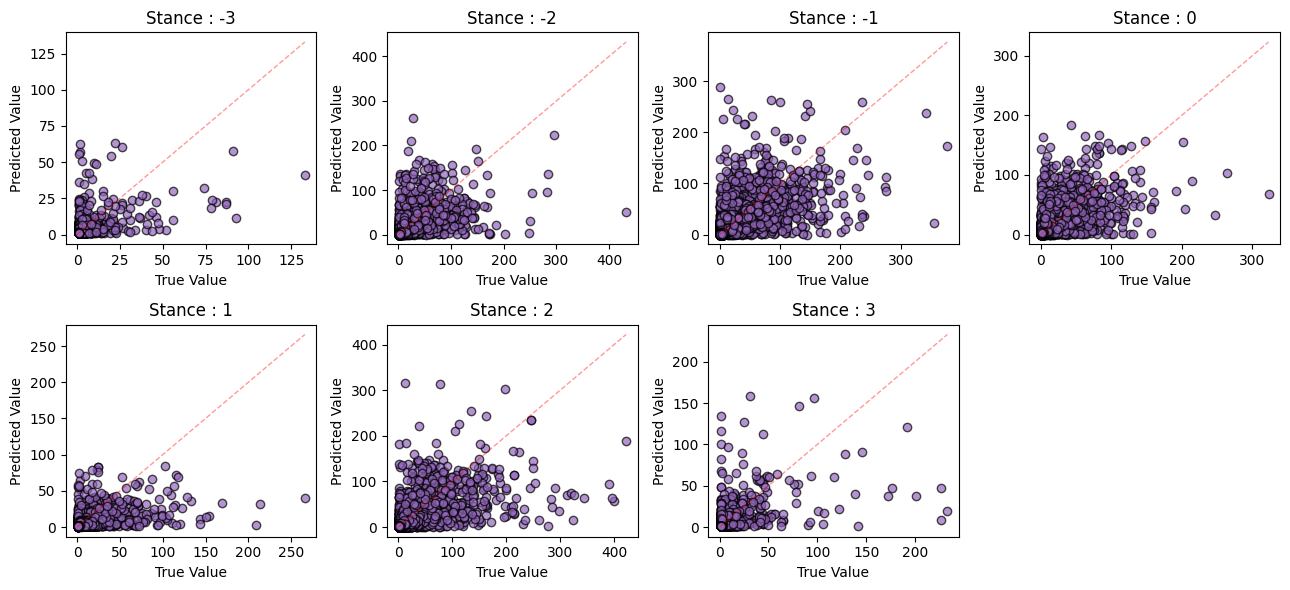

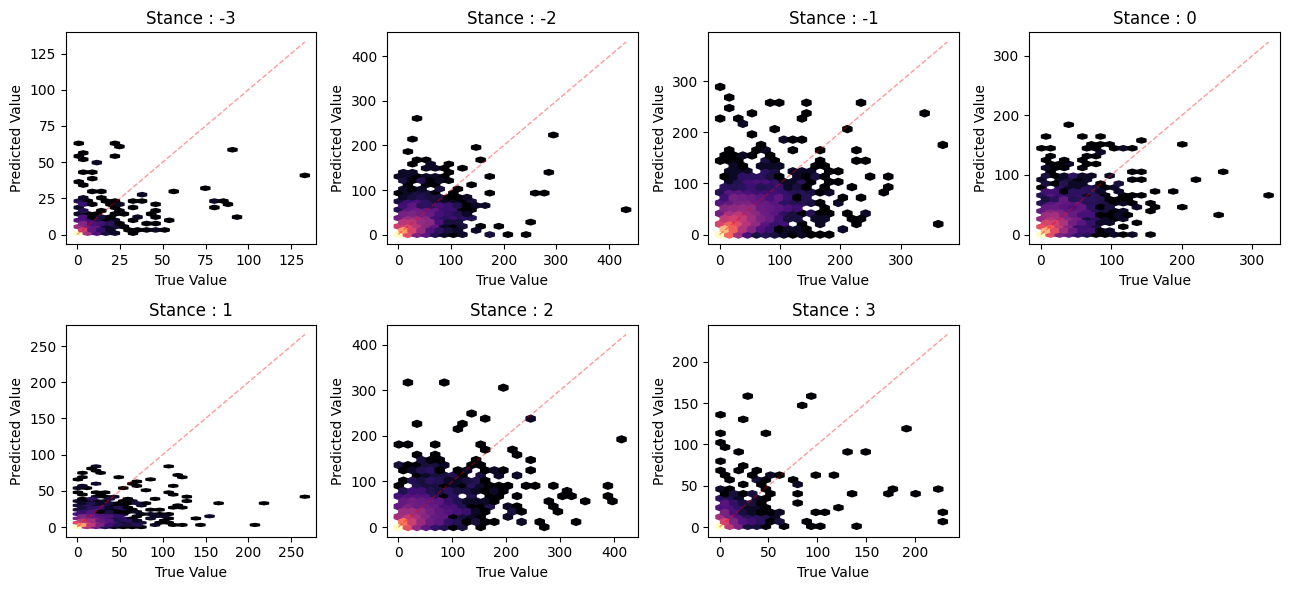

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,4.875974,119.371292,212.941116,94.421753,40.235996,196.256760,24.849512,98.993200,692.952403
1,mae,0.262074,3.442551,5.553530,3.528714,1.448216,3.423275,0.669031,2.618199,18.327391
2,mape,0.103653,0.598707,0.791670,0.691287,0.307779,0.484645,0.222538,0.457182,3.200277
3,smape,0.134875,0.169662,0.062932,0.033411,0.215539,0.258932,0.229785,0.157877,1.105136
4,nmse,0.775440,0.621825,0.562269,0.636164,0.693809,0.574343,0.795148,0.665571,4.658998


By Quarter :

Quarter 1:
Num samples - Truth : (5282, 7)
Num samples - Preds : (5282, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.754703,130.904205,194.298386,89.179375,43.384182,187.161194,21.553185,95.747890,670.235229
1,mae,0.232960,3.347724,5.124470,3.330900,1.320183,3.259507,0.645761,2.465929,17.261506
2,mape,0.100820,0.567205,0.800456,0.619158,0.276346,0.460673,0.228676,0.436191,3.053335
3,smape,0.126819,0.163648,0.062402,0.031012,0.211076,0.250365,0.222820,0.152592,1.068143
4,nmse,0.974446,0.628319,0.522602,0.593706,0.683071,0.523013,0.629440,0.650657,4.554596


Quarter 2:
Num samples - Truth : (5418, 7)
Num samples - Preds : (5418, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.384981,122.519333,209.572678,88.291191,35.733597,199.448181,28.686710,98.233810,687.636671
1,mae,0.243667,3.290072,5.347454,3.427277,1.359399,3.358188,0.679192,2.529321,17.705249
2,mape,0.116074,0.631402,0.794528,0.696067,0.318298,0.488803,0.229517,0.467813,3.274689
3,smape,0.131920,0.166787,0.063197,0.034073,0.212535,0.258418,0.227322,0.156322,1.094251
4,nmse,0.969456,0.629289,0.553735,0.641890,0.742167,0.612576,1.001047,0.735737,5.150160


Quarter 3:
Num samples - Truth : (5551, 7)
Num samples - Preds : (5551, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,6.317337,123.294113,224.227615,106.959587,36.276176,205.199112,29.708912,104.568979,731.982853
1,mae,0.284296,3.576810,5.759685,3.713555,1.509689,3.514509,0.711344,2.724270,19.069888
2,mape,0.096496,0.595393,0.755883,0.703482,0.314118,0.494098,0.226470,0.455134,3.185940
3,smape,0.139415,0.171130,0.063755,0.033946,0.217618,0.259845,0.233445,0.159879,1.119154
4,nmse,0.737211,0.595654,0.542460,0.638756,0.652763,0.547352,0.817211,0.647344,4.531407


Quarter 4:
Num samples - Truth : (5630, 7)
Num samples - Preds : (5630, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,5.941645,101.653938,222.545029,92.877876,45.519505,192.901947,19.458178,97.271160,680.898118
1,mae,0.285192,3.545878,5.951127,3.629673,1.593196,3.549603,0.639365,2.742005,19.194034
2,mape,0.101412,0.600064,0.815962,0.742334,0.320894,0.493813,0.206186,0.468666,3.280664
3,smape,0.140802,0.176621,0.062361,0.034499,0.220569,0.266563,0.235082,0.162357,1.136497
4,nmse,0.659324,0.639214,0.634208,0.671138,0.705222,0.623928,0.751013,0.669150,4.684048


21881it [00:02, 8033.39it/s]



Top : 100

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,22.200184,671.312744,285.996490,172.995255,43.197754,265.801575,388.096313,264.228616,1849.600315
1,mae,0.520023,8.050167,8.580070,6.080309,2.370187,7.130204,4.229867,5.280118,36.960827
2,mape,0.054814,2.733685,2.047805,2.415098,0.594613,2.365716,0.817092,1.575546,11.028824
3,smape,0.022265,0.341435,0.502851,0.388722,0.192679,0.312750,0.107998,0.266957,1.868699
4,nmse,1.015116,1.381229,3.301722,2.476246,0.885238,1.299649,1.102464,1.637381,11.461664



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,19.401970,556.643921,145.987946,371.847534,54.282928,231.788834,355.346405,247.899934,1735.299538
1,mae,0.481394,7.199112,7.036026,6.484153,2.437455,6.165843,3.702600,4.786655,33.506583
2,mape,0.045433,1.939767,1.740988,2.193749,0.630307,1.220975,0.374501,1.163674,8.145719
3,smape,0.023965,0.338580,0.451786,0.359408,0.187035,0.296441,0.096452,0.250524,1.753668
4,nmse,0.887166,1.145298,1.685376,5.322608,1.112403,1.133342,1.009431,1.756518,12.295624



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,4.920222,9832.650391,17555.042969,6099.592285,2326.406738,16010.325195,780.703674,7515.663068,52609.641475
1,mae,0.880065,68.821518,99.161720,59.809380,23.181089,83.282639,8.179898,49.045187,343.316309
2,mape,0.397217,7.214139,9.258226,5.868327,3.281361,4.571546,1.398481,4.569899,31.989296
3,smape,0.138884,0.590045,0.603890,0.605455,0.447434,0.564191,0.257077,0.458139,3.206976
4,nmse,1.531301,1.653156,2.686934,1.972593,1.694089,1.406352,0.851304,1.685104,11.795729



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.455177,6993.629395,11079.523438,4387.018555,1452.137329,10475.154297,750.036560,5020.136393,35140.954750
1,mae,0.680286,52.073395,75.154984,46.899681,16.500389,54.994312,6.781590,36.154948,253.084637
2,mape,0.222319,4.183439,5.544323,3.709811,1.213211,2.032217,0.583501,2.498403,17.488821
3,smape,0.120719,0.544879,0.551249,0.559493,0.423634,0.486759,0.223243,0.415711,2.909975
4,nmse,1.075341,1.175833,1.695806,1.418751,1.057446,0.920141,0.817864,1.165883,8.161182



Top : 500

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,29.528582,335.913269,679.938904,148.080414,24.884192,366.789062,107.302727,241.776736,1692.437149
1,mae,0.809979,5.700430,7.824270,4.502031,1.888042,5.976067,1.581979,4.040400,28.282798
2,mape,0.247125,2.230553,3.113359,1.837560,0.624428,1.902298,0.356830,1.473165,10.312153
3,smape,0.053787,0.343827,0.493875,0.374857,0.196566,0.303995,0.070682,0.262513,1.837590
4,nmse,1.201772,2.132432,6.028558,2.091312,1.115606,1.215047,1.046634,2.118766,14.831361



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,23.831018,242.597382,379.038269,174.402191,28.136517,550.763855,100.729477,214.214101,1499.498709
1,mae,0.679880,5.224544,7.156474,4.397190,1.791161,6.105016,1.539494,3.841965,26.893757
2,mape,0.201328,1.818102,2.805633,1.934869,0.591773,1.936608,0.334025,1.374620,9.622337
3,smape,0.047194,0.335929,0.442927,0.339334,0.189414,0.278266,0.081208,0.244896,1.714272
4,nmse,0.969889,1.540048,3.360676,2.463050,1.261414,1.824492,0.982518,1.771727,12.402087



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,47.848835,3042.861328,5841.689453,2228.325195,831.352112,5343.359375,414.353058,2535.684194,17749.789356
1,mae,1.352139,33.859921,53.006145,32.537922,13.150316,43.447208,5.796298,26.164279,183.149950
2,mape,0.349445,2.996683,3.574666,2.672657,1.632937,2.373669,0.818446,2.059786,14.418503
3,smape,0.105868,0.460654,0.499754,0.491906,0.366388,0.446945,0.207999,0.368502,2.579514
4,nmse,0.566847,1.332243,1.685263,1.434400,1.218328,0.946649,0.870736,1.150638,8.054466



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,45.227474,2368.757568,4174.216309,1637.653442,641.623413,4826.845215,394.650116,2012.710505,14088.973537
1,mae,1.238525,28.115215,42.359352,26.134825,10.797562,36.351593,4.928903,21.417996,149.925975
2,mape,0.267524,1.922552,2.277234,1.882127,0.802553,1.354185,0.576269,1.297492,9.082444
3,smape,0.107031,0.441850,0.458539,0.449692,0.364207,0.421811,0.201466,0.349228,2.444595
4,nmse,0.535793,1.037103,1.204215,1.054177,0.940285,0.855141,0.829332,0.922292,6.456047



Top : 1000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,15.665713,226.592911,418.562195,121.136902,25.944637,334.289062,65.440788,172.518887,1207.632209
1,mae,0.530033,4.736176,6.959165,4.123130,1.794031,5.321023,1.186054,3.521373,24.649612
2,mape,0.170879,1.782798,2.574829,1.580147,0.559245,1.489366,0.268581,1.203692,8.425844
3,smape,0.041959,0.336665,0.495753,0.363551,0.198391,0.288943,0.067871,0.256162,1.793133
4,nmse,0.968244,1.934682,3.427406,1.594905,1.262515,1.182484,1.121219,1.641636,11.491454



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,15.298340,172.873322,275.151428,160.139587,24.296267,415.546661,58.266472,160.224582,1121.572077
1,mae,0.512872,4.290405,6.434564,4.153150,1.644367,5.179137,1.141224,3.336531,23.355718
2,mape,0.165039,1.422176,2.409592,1.701607,0.507423,1.428639,0.272269,1.129535,7.906746
3,smape,0.040640,0.320661,0.437514,0.336649,0.187441,0.263281,0.078077,0.237752,1.664262
4,nmse,0.945538,1.476017,2.253084,2.108419,1.182302,1.469917,0.998299,1.490511,10.433576



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,37.057541,1761.489990,3335.066650,1337.817993,492.405487,3069.133057,237.450089,1467.202972,10270.420807
1,mae,1.204122,24.769665,38.059265,23.794954,9.897118,31.270699,4.192217,19.026863,133.188040
2,mape,0.325180,2.133549,2.444923,2.007548,1.271970,1.897786,0.657212,1.534024,10.738169
3,smape,0.097401,0.415161,0.444926,0.427146,0.333949,0.402504,0.180532,0.328803,2.301620
4,nmse,0.564334,1.053140,1.274362,1.140782,0.794069,0.817461,0.746699,0.912978,6.390846



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,43.819889,1510.677368,2640.075195,1152.949463,535.108154,3004.435547,251.992477,1305.579728,9139.058094
1,mae,1.281932,22.114275,32.954025,21.389446,9.460253,27.819309,4.081339,17.014369,119.100580
2,mape,0.310336,1.595693,1.756954,1.664701,0.714847,1.301589,0.511491,1.122230,7.855612
3,smape,0.103566,0.410970,0.420019,0.416187,0.346487,0.386713,0.189546,0.324784,2.273488
4,nmse,0.667315,0.903187,1.008799,0.983141,0.862932,0.800229,0.792430,0.859719,6.018033



Top : 2000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,9.573733,154.979218,262.054749,81.521721,18.261158,219.057068,45.843517,113.041595,791.291163
1,mae,0.398015,3.957653,5.944149,3.561610,1.497564,3.985584,0.899550,2.892018,20.244124
2,mape,0.138515,1.426693,2.066160,1.364635,0.493925,1.122279,0.229728,0.977419,6.841936
3,smape,0.037010,0.317591,0.464879,0.350616,0.181224,0.263092,0.062934,0.239621,1.677346
4,nmse,1.091276,1.749588,2.913532,1.619192,1.213387,0.912385,1.452722,1.564583,10.952082



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,11.089684,127.543060,187.460571,100.941994,17.738127,292.187103,34.007591,110.138304,770.968131
1,mae,0.417321,3.591587,5.424276,3.449598,1.356684,3.862754,0.837449,2.705667,18.939670
2,mape,0.154173,1.167339,1.874344,1.345193,0.421354,1.029520,0.257000,0.892704,6.248925
3,smape,0.038120,0.297084,0.403025,0.321610,0.167709,0.236215,0.073805,0.219653,1.537568
4,nmse,1.264074,1.439857,2.084192,2.004919,1.178633,1.216975,1.077657,1.466615,10.266307



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,23.286180,995.614014,1880.120728,758.136047,281.377106,1654.859009,131.687103,817.868598,5725.080187
1,mae,0.927588,17.916855,27.582031,16.852964,7.063575,20.423319,2.934656,13.385855,93.700988
2,mape,0.258795,1.654567,1.865669,1.554179,0.978168,1.490437,0.522037,1.189122,8.323852
3,smape,0.086079,0.377666,0.400531,0.387041,0.294824,0.352040,0.156474,0.293522,2.054655
4,nmse,0.495437,0.878863,1.035695,0.958167,0.670965,0.680529,0.619474,0.762733,5.339128



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,30.972504,941.960632,1691.885498,716.549500,338.772827,1744.828125,151.549728,802.359831,5616.518814
1,mae,1.066482,17.148489,25.856804,16.249651,7.190671,19.231520,2.935475,12.811299,89.679092
2,mape,0.291672,1.345168,1.693409,1.495608,0.612736,1.128541,0.411089,0.996889,6.978223
3,smape,0.093468,0.380596,0.388225,0.385792,0.310354,0.352178,0.161447,0.296008,2.072059
4,nmse,0.658971,0.831501,0.932002,0.905608,0.807829,0.717527,0.712910,0.795193,5.566348



Top : 4000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,5.745424,95.190536,166.251755,61.951180,35.781834,154.865601,27.520008,78.186620,547.306337
1,mae,0.298261,3.255137,5.046911,3.279587,1.456593,3.274298,0.671795,2.468940,17.282582
2,mape,0.110361,1.156080,1.646708,1.175885,0.507573,0.906048,0.211254,0.816273,5.713909
3,smape,0.033765,0.298294,0.421049,0.332982,0.168529,0.234458,0.059367,0.221206,1.548445
4,nmse,0.705828,1.596359,2.310297,1.462067,2.112693,1.093323,1.557986,1.548365,10.838552



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,9.078987,81.468445,129.660736,72.364517,18.450453,173.717667,19.509388,72.035742,504.250193
1,mae,0.365748,2.987857,4.679852,3.163483,1.274028,3.111816,0.645163,2.318278,16.227948
2,mape,0.147066,0.962769,1.526339,1.142547,0.400526,0.815650,0.234430,0.747046,5.229325
3,smape,0.037646,0.277930,0.368576,0.306716,0.159421,0.215898,0.070447,0.205234,1.436636
4,nmse,1.115358,1.366237,1.801814,1.707825,1.089384,1.226415,1.104482,1.344502,9.411515



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,13.393244,533.192932,1013.252625,414.064392,153.231186,864.736816,70.721970,437.513309,3062.593164
1,mae,0.661300,12.008710,18.775684,11.571565,4.908091,12.978910,1.993601,8.985409,62.897860
2,mape,0.197645,1.290953,1.432118,1.256187,0.810618,1.152771,0.424525,0.937831,6.564817
3,smape,0.069643,0.345484,0.365200,0.351374,0.267749,0.312633,0.135625,0.263958,1.847707
4,nmse,0.496296,0.735473,0.814579,0.802644,0.602004,0.586006,0.507340,0.649192,4.544343



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,21.255941,549.757324,1006.071106,447.367218,199.049316,993.311340,101.989761,474.114573,3318.802008
1,mae,0.826436,12.280562,18.990040,11.946923,5.179944,13.272485,2.241609,9.248286,64.737999
2,mape,0.253025,1.180693,1.431097,1.344627,0.587833,0.989610,0.402202,0.884155,6.189087
3,smape,0.080042,0.353180,0.364052,0.355147,0.280023,0.320537,0.144186,0.271024,1.897166
4,nmse,0.787654,0.758321,0.808806,0.867200,0.782012,0.673137,0.731647,0.772682,5.408777



Top : 6000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,4.338411,83.474312,142.583496,59.642418,27.419037,123.779457,19.314861,65.793142,460.551992
1,mae,0.250682,2.967801,4.655824,3.070092,1.313249,2.900409,0.564535,2.246085,15.722593
2,mape,0.092515,0.990942,1.406102,1.049488,0.462752,0.768980,0.187016,0.708256,4.957795
3,smape,0.029670,0.278946,0.389610,0.312262,0.156148,0.215534,0.055937,0.205444,1.438108
4,nmse,0.570965,1.404801,1.804707,1.372161,1.787289,1.077286,1.356390,1.339085,9.373598



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,6.790966,71.324951,127.152351,64.128960,16.042912,131.593475,17.592852,62.089495,434.626467
1,mae,0.307107,2.718732,4.389775,2.909261,1.164939,2.752339,0.605848,2.121143,14.848001
2,mape,0.123141,0.830886,1.308037,0.980898,0.367149,0.686093,0.226622,0.646118,4.522827
3,smape,0.033827,0.263000,0.346886,0.289142,0.149987,0.201549,0.066983,0.193053,1.351374
4,nmse,0.893738,1.200338,1.609392,1.475380,1.045745,1.145293,1.235461,1.229335,8.605347



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,9.521687,363.537842,693.187561,284.595123,105.645966,583.733154,47.975014,298.313764,2088.196346
1,mae,0.529374,9.189680,14.546259,8.999236,3.854588,9.609805,1.493078,6.888860,48.222020
2,mape,0.166763,1.130680,1.270834,1.126963,0.722374,0.968288,0.349487,0.819341,5.735390
3,smape,0.058146,0.327134,0.349102,0.333403,0.247901,0.284487,0.115520,0.245099,1.715693
4,nmse,0.488372,0.669581,0.722038,0.719360,0.569611,0.543028,0.481820,0.599116,4.193810



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,15.208264,404.488678,730.145996,322.016327,139.454788,693.223145,71.597290,339.447784,2376.134488
1,mae,0.653018,9.777090,15.261573,9.622018,4.094793,10.212639,1.747771,7.338414,51.368901
2,mape,0.214570,1.080884,1.301490,1.240498,0.540149,0.851986,0.361217,0.798685,5.590794
3,smape,0.068474,0.336059,0.350442,0.341419,0.256385,0.292888,0.126691,0.253194,1.772357
4,nmse,0.780040,0.745006,0.760534,0.813948,0.751898,0.644883,0.719062,0.745053,5.215371




No-Engagement ---> Engagement :
Data Size : 1541
Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,1.691875,47.698086,25.366764,16.867355,5.531624,19.440899,22.273752,19.838622,138.870355
1,mae,0.119087,1.213428,1.699237,1.148884,0.484787,0.952215,0.402701,0.860048,6.020339
2,mape,0.040791,0.302673,0.440321,0.334308,0.164026,0.272108,0.163054,0.245326,1.717279
3,smape,0.081513,0.130043,0.036193,0.017548,0.172020,0.264115,0.193288,0.127817,0.894719
4,nmse,0.813792,1.036961,1.065248,1.003340,1.039349,0.992234,1.381117,1.047434,7.332040


Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,2.092505,47.312469,26.983665,18.077560,5.498946,20.388081,16.186829,19.505722,136.540056
1,mae,0.117448,1.146731,1.780785,1.124691,0.420525,0.891742,0.243993,0.817988,5.725915
2,mape,0.019061,0.202373,0.370387,0.237784,0.090161,0.153077,0.028853,0.157385,1.101696
3,smape,0.066873,0.115842,0.021669,0.014654,0.151231,0.278984,0.176800,0.118008,0.826053
4,nmse,1.006495,1.028577,1.133148,1.075328,1.033209,1.040577,1.003688,1.045860,7.321022




Engagement ---> No-Engagement :
Data Size : 1638
Model


/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,a

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,1.234768,24.423555,93.668152,37.751415,4.516406,45.197906,0.883756,29.667994,207.675958
1,mae,0.121956,0.868312,1.739027,1.071966,0.293510,0.845382,0.141951,0.726015,5.082104
2,mape,0.121956,0.868312,1.739027,1.071966,0.293510,0.845382,0.141951,0.726015,5.082104
3,smape,0.057558,0.101708,0.028923,0.018769,0.139771,0.241836,0.156349,0.106416,0.744915
4,nmse,inf,inf,inf,inf,inf,inf,inf,inf,inf


Baseline


/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,a

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,0.512182,48.246994,164.299545,18.647955,1.943920,9.840636,2.314733,35.115138,245.805965
1,mae,0.075093,0.897042,1.702868,0.908601,0.224093,0.646009,0.116628,0.652905,4.570335
2,mape,0.075093,0.897042,1.702868,0.908601,0.224094,0.646009,0.116628,0.652905,4.570335
3,smape,0.047498,0.096954,0.017429,0.012748,0.128328,0.257031,0.161702,0.103099,0.721691
4,nmse,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_count = LSTMForecasterSF(input_size=3072, 
                          hidden_dim_lstm=32,
                          num_layers=1,
                          bidirectional=True,
                          output_size=7, 
                          activation="sigmoid")

loss = nn.L1Loss(reduction="mean")

model_count= nn.DataParallel(model_count)
model_count.to(device)

scores, model_count = trainer(train_dataset,
                   val_dataset,
                   model_count,
                   loss,
                   device,
                   epochs=300,
                   patience=5,
                   batch_size=64,
                   debug=False,
                   sf=2,
                   lr=0.001,
                   chpath="test_ground/text_checkpoint_run1.pt")

ranked_scores = predict_and_evaluate_test(r1_test,
                                          model_count,
                                          device,
                                          sf=2,
                                          save_path="test_ground/preds_model_text_run1.pkl")

model_count = None
        
del model_count

torch.cuda.empty_cache()

Train : 246
Val : 61


Epoch:   4%|▏  | 13/300 [01:39<36:33,  7.64s/it, train_loss=6.67, val_loss=6.75]


Early stopping
Overall Performance :



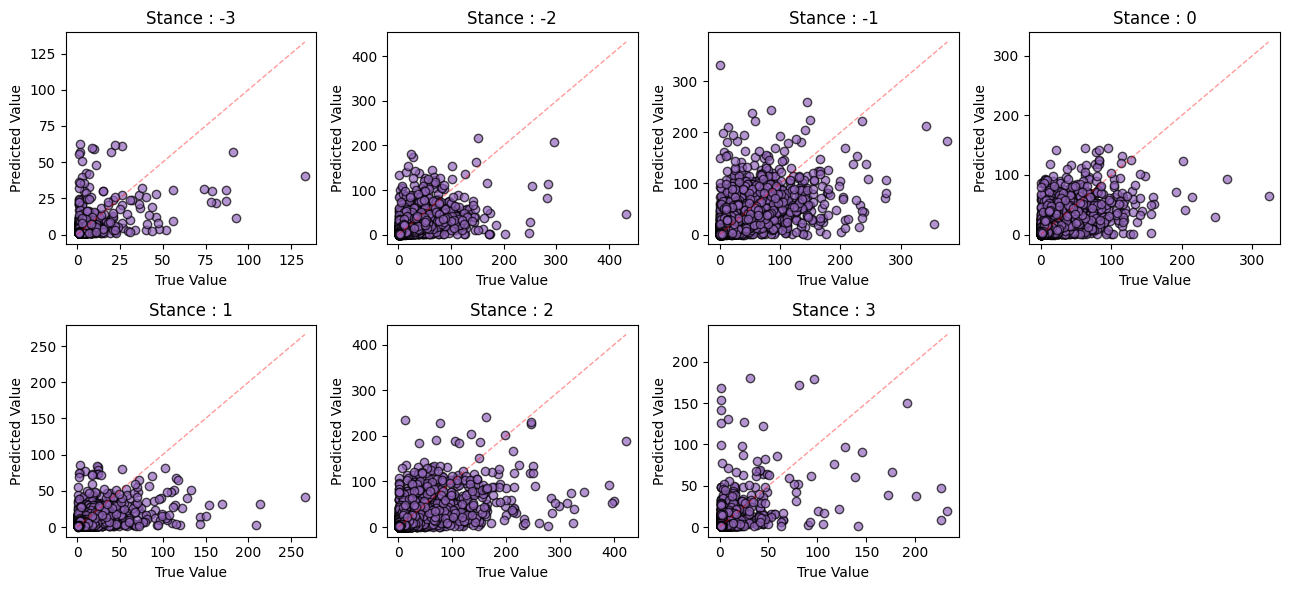

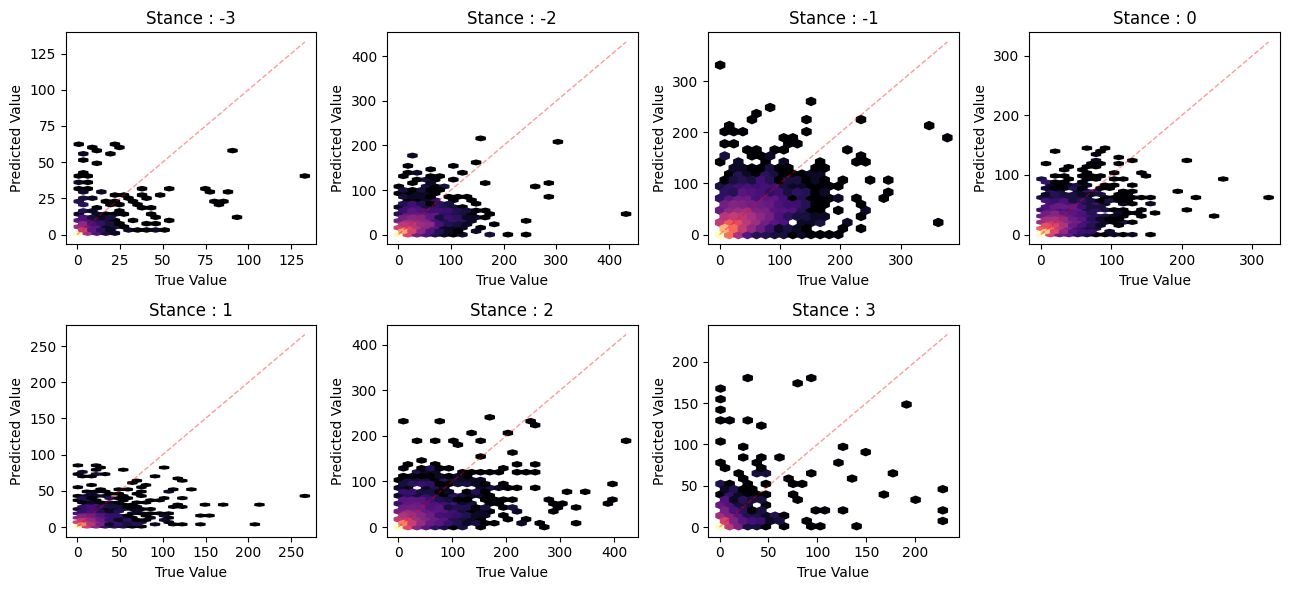

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,5.033844,112.035934,206.812714,83.768593,39.783253,199.584503,28.994490,96.573333,676.013330
1,mae,0.267422,3.352740,5.436430,3.358566,1.460684,3.564836,0.734499,2.596454,18.175176
2,mape,0.107011,0.561964,0.758086,0.655778,0.328174,0.547085,0.258334,0.459490,3.216431
3,smape,0.136350,0.178180,0.065467,0.033548,0.212294,0.253321,0.226711,0.157982,1.105871
4,nmse,0.800547,0.583614,0.546087,0.564389,0.686002,0.584081,0.927782,0.670357,4.692501


By Quarter :

Quarter 1:
Num samples - Truth : (5282, 7)
Num samples - Preds : (5282, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.883408,132.426193,200.961243,82.765427,43.204918,191.740631,23.408859,96.912954,678.390679
1,mae,0.237126,3.338138,5.108859,3.230065,1.337751,3.385809,0.686346,2.474871,17.324094
2,mape,0.104524,0.576403,0.818600,0.626584,0.296745,0.526513,0.255762,0.457876,3.205131
3,smape,0.128614,0.171956,0.064199,0.031248,0.210297,0.245693,0.221197,0.153315,1.073205
4,nmse,1.007848,0.635624,0.540523,0.551005,0.680248,0.535810,0.683633,0.662099,4.634692


Quarter 2:
Num samples - Truth : (5418, 7)
Num samples - Preds : (5418, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.444973,111.176208,200.935120,74.340126,35.705257,200.374329,32.439400,94.059345,658.415413
1,mae,0.245328,3.160369,5.161397,3.217556,1.363953,3.453199,0.740261,2.477438,17.342064
2,mape,0.119172,0.547178,0.703553,0.618844,0.329360,0.539086,0.260776,0.445424,3.117969
3,smape,0.132712,0.174923,0.065434,0.034022,0.207101,0.251995,0.222689,0.155554,1.088876
4,nmse,0.986638,0.571028,0.530913,0.540464,0.741578,0.615420,1.132001,0.731149,5.118041


Quarter 3:
Num samples - Truth : (5551, 7)
Num samples - Preds : (5551, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,6.511969,116.206757,216.249237,96.569489,35.612747,210.309723,34.957401,102.345332,716.417322
1,mae,0.290920,3.492147,5.652395,3.544682,1.528273,3.691655,0.785958,2.712290,18.986030
2,mape,0.099164,0.565595,0.724040,0.669412,0.334754,0.556210,0.268679,0.459694,3.217855
3,smape,0.140918,0.179805,0.066439,0.034140,0.214123,0.254465,0.230955,0.160121,1.120845
4,nmse,0.759924,0.561414,0.523158,0.576707,0.640825,0.560985,0.961582,0.654942,4.584594


Quarter 4:
Num samples - Truth : (5630, 7)
Num samples - Preds : (5630, 7)


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,6.184826,89.621040,208.654617,81.161934,44.609501,195.608704,25.040430,92.983007,650.881052
1,mae,0.293940,3.414114,5.795495,3.431321,1.602464,3.715189,0.723393,2.710845,18.975916
2,mape,0.105379,0.559067,0.787360,0.705268,0.350029,0.565085,0.248194,0.474340,3.320382
3,smape,0.142606,0.185550,0.065729,0.034666,0.217362,0.260626,0.231570,0.162587,1.138109
4,nmse,0.686309,0.563549,0.594624,0.586478,0.691124,0.632683,0.966468,0.674462,4.721234


21881it [00:02, 8162.50it/s]



Top : 100

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,22.200184,671.312744,285.996490,172.995255,43.197754,265.801575,388.096313,264.228616,1849.600315
1,mae,0.520023,8.050167,8.580070,6.080309,2.370187,7.130204,4.229867,5.280118,36.960827
2,mape,0.054814,2.733685,2.047805,2.415098,0.594613,2.365716,0.817092,1.575546,11.028824
3,smape,0.022265,0.341435,0.502851,0.388722,0.192679,0.312750,0.107998,0.266957,1.868699
4,nmse,1.015116,1.381229,3.301722,2.476246,0.885238,1.299649,1.102464,1.637381,11.461664



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,19.404730,552.239746,168.992676,179.704544,69.990189,234.395737,355.330597,225.722603,1580.058218
1,mae,0.481273,7.104743,7.218995,5.614273,2.563998,6.109994,3.707397,4.685810,32.800670
2,mape,0.045279,1.924032,1.891453,1.921808,0.705002,1.076747,0.380077,1.134914,7.944398
3,smape,0.023921,0.335874,0.440897,0.357807,0.189547,0.295849,0.097196,0.248727,1.741091
4,nmse,0.887292,1.136236,1.950957,2.572282,1.434287,1.146089,1.009386,1.448076,10.136530



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,4.920222,9832.650391,17555.042969,6099.592285,2326.406738,16010.325195,780.703674,7515.663068,52609.641475
1,mae,0.880065,68.821518,99.161720,59.809380,23.181089,83.282639,8.179898,49.045187,343.316309
2,mape,0.397217,7.214139,9.258226,5.868327,3.281361,4.571546,1.398481,4.569899,31.989296
3,smape,0.138884,0.590045,0.603890,0.605455,0.447434,0.564191,0.257077,0.458139,3.206976
4,nmse,1.531301,1.653156,2.686934,1.972593,1.694089,1.406352,0.851304,1.685104,11.795729



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,3.451081,7079.136719,11126.405273,4355.762207,1422.479370,10633.848633,795.194824,5059.468301,35416.278107
1,mae,0.679751,52.279343,75.132576,46.057831,16.124645,54.477085,7.079251,35.975783,251.830483
2,mape,0.222225,4.053426,5.993336,3.619337,1.213241,1.594686,0.623090,2.474192,17.319341
3,smape,0.120673,0.547687,0.556054,0.562911,0.417696,0.496731,0.228129,0.418555,2.929882
4,nmse,1.074066,1.190210,1.702982,1.408643,1.035850,0.934080,0.867106,1.173277,8.212936



Top : 500

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,29.528582,335.913269,679.938904,148.080414,24.884192,366.789062,107.302727,241.776736,1692.437149
1,mae,0.809979,5.700430,7.824270,4.502031,1.888042,5.976067,1.581979,4.040400,28.282798
2,mape,0.247125,2.230553,3.113359,1.837560,0.624428,1.902298,0.356830,1.473165,10.312153
3,smape,0.053787,0.343827,0.493875,0.374857,0.196566,0.303995,0.070682,0.262513,1.837590
4,nmse,1.201772,2.132432,6.028558,2.091312,1.115606,1.215047,1.046634,2.118766,14.831361



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,27.273247,229.798035,432.348175,122.589149,31.236465,390.219360,100.443733,190.558309,1333.908165
1,mae,0.743683,4.988363,7.185400,4.044270,1.824216,5.580316,1.539873,3.700874,25.906120
2,mape,0.237646,1.689473,2.874504,1.765428,0.619678,1.609641,0.346639,1.306144,9.143009
3,smape,0.047390,0.329360,0.436087,0.336118,0.189427,0.278876,0.082185,0.242778,1.699443
4,nmse,1.109983,1.458795,3.833339,1.731304,1.400391,1.292663,0.979731,1.686601,11.806206



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,47.848835,3042.861328,5841.689453,2228.325195,831.352112,5343.359375,414.353058,2535.684194,17749.789356
1,mae,1.352139,33.859921,53.006145,32.537922,13.150316,43.447208,5.796298,26.164279,183.149950
2,mape,0.349445,2.996683,3.574666,2.672657,1.632937,2.373669,0.818446,2.059786,14.418503
3,smape,0.105868,0.460654,0.499754,0.491906,0.366388,0.446945,0.207999,0.368502,2.579514
4,nmse,0.566847,1.332243,1.685263,1.434400,1.218328,0.946649,0.870736,1.150638,8.054466



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,46.042603,2390.354736,4213.142578,1641.410278,632.364502,4815.005859,424.692810,2023.287624,14163.013367
1,mae,1.246846,27.963207,42.467686,25.608126,10.663455,36.351456,5.238023,21.362685,149.538798
2,mape,0.268567,1.781055,2.348306,1.755030,0.825969,1.205154,0.638048,1.260304,8.822128
3,smape,0.107015,0.444920,0.462261,0.448813,0.360198,0.435651,0.205836,0.352099,2.464695
4,nmse,0.545450,1.046559,1.215445,1.056596,0.926716,0.853044,0.892465,0.933753,6.536274



Top : 1000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,15.665713,226.592911,418.562195,121.136902,25.944637,334.289062,65.440788,172.518887,1207.632209
1,mae,0.530033,4.736176,6.959165,4.123130,1.794031,5.321023,1.186054,3.521373,24.649612
2,mape,0.170879,1.782798,2.574829,1.580147,0.559245,1.489366,0.268581,1.203692,8.425844
3,smape,0.041959,0.336665,0.495753,0.363551,0.198391,0.288943,0.067871,0.256162,1.793133
4,nmse,0.968244,1.934682,3.427406,1.594905,1.262515,1.182484,1.121219,1.641636,11.491454



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,17.273262,161.464996,293.579956,115.733643,26.275719,329.724426,58.941673,143.284811,1002.993675
1,mae,0.552439,4.112189,6.381763,3.889262,1.673997,4.858129,1.165763,3.233363,22.633542
2,mape,0.184834,1.327004,2.368904,1.541891,0.530838,1.242421,0.288795,1.069241,7.484688
3,smape,0.040842,0.314382,0.432865,0.331699,0.188245,0.264820,0.079771,0.236089,1.652625
4,nmse,1.067601,1.378611,2.403986,1.523765,1.278626,1.166338,1.009867,1.404113,9.828794



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,37.057541,1761.489990,3335.066650,1337.817993,492.405487,3069.133057,237.450089,1467.202972,10270.420807
1,mae,1.204122,24.769665,38.059265,23.794954,9.897118,31.270699,4.192217,19.026863,133.188040
2,mape,0.325180,2.133549,2.444923,2.007548,1.271970,1.897786,0.657212,1.534024,10.738169
3,smape,0.097401,0.415161,0.444926,0.427146,0.333949,0.402504,0.180532,0.328803,2.301620
4,nmse,0.564334,1.053140,1.274362,1.140782,0.794069,0.817461,0.746699,0.912978,6.390846



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,45.229652,1537.642334,2668.926025,1118.651123,521.905396,3005.527588,266.180786,1309.151843,9164.062904
1,mae,1.304841,22.184341,32.988289,20.785192,9.318619,27.970833,4.265485,16.973943,118.817601
2,mape,0.317411,1.447517,1.777219,1.496184,0.740592,1.140953,0.563852,1.069104,7.483727
3,smape,0.103667,0.415267,0.421746,0.414422,0.342656,0.401611,0.192983,0.327479,2.292351
4,nmse,0.688783,0.919309,1.019823,0.953894,0.841641,0.800520,0.837047,0.865860,6.061017



Top : 2000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,9.573733,154.979218,262.054749,81.521721,18.261158,219.057068,45.843517,113.041595,791.291163
1,mae,0.398015,3.957653,5.944149,3.561610,1.497564,3.985584,0.899550,2.892018,20.244124
2,mape,0.138515,1.426693,2.066160,1.364635,0.493925,1.122279,0.229728,0.977419,6.841936
3,smape,0.037010,0.317591,0.464879,0.350616,0.181224,0.263092,0.062934,0.239621,1.677346
4,nmse,1.091276,1.749588,2.913532,1.619192,1.213387,0.912385,1.452722,1.564583,10.952082



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,12.694133,113.815140,191.142044,74.893028,20.241140,250.037506,36.680882,99.929125,699.503873
1,mae,0.447256,3.429398,5.343222,3.252144,1.394740,3.770800,0.882745,2.645758,18.520305
2,mape,0.166264,1.075479,1.829890,1.263589,0.442831,0.966288,0.275965,0.860044,6.020305
3,smape,0.038263,0.291485,0.399021,0.315727,0.168838,0.239319,0.075539,0.218313,1.528193
4,nmse,1.446959,1.284880,2.125123,1.487532,1.344949,1.041420,1.162370,1.413319,9.893233



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,23.286180,995.614014,1880.120728,758.136047,281.377106,1654.859009,131.687103,817.868598,5725.080187
1,mae,0.927588,17.916855,27.582031,16.852964,7.063575,20.423319,2.934656,13.385855,93.700988
2,mape,0.258795,1.654567,1.865669,1.554179,0.978168,1.490437,0.522037,1.189122,8.323852
3,smape,0.086079,0.377666,0.400531,0.387041,0.294824,0.352040,0.156474,0.293522,2.054655
4,nmse,0.495437,0.878863,1.035695,0.958167,0.670965,0.680529,0.619474,0.762733,5.339128



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,31.016325,947.193848,1685.158447,678.572144,329.767487,1748.371094,159.163116,797.034637,5579.242460
1,mae,1.071019,17.112970,25.733215,15.682796,7.099847,19.421688,3.096819,12.745479,89.218355
2,mape,0.295862,1.217079,1.674430,1.338572,0.647994,0.999968,0.462895,0.948114,6.636801
3,smape,0.093334,0.385324,0.389457,0.384802,0.307848,0.365585,0.166033,0.298912,2.092383
4,nmse,0.659903,0.836121,0.928297,0.857610,0.786355,0.718984,0.748724,0.790856,5.535994



Top : 4000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,5.745424,95.190536,166.251755,61.951180,35.781834,154.865601,27.520008,78.186620,547.306337
1,mae,0.298261,3.255137,5.046911,3.279587,1.456593,3.274298,0.671795,2.468940,17.282582
2,mape,0.110361,1.156080,1.646708,1.175885,0.507573,0.906048,0.211254,0.816273,5.713909
3,smape,0.033765,0.298294,0.421049,0.332982,0.168529,0.234458,0.059367,0.221206,1.548445
4,nmse,0.705828,1.596359,2.310297,1.462067,2.112693,1.093323,1.557986,1.548365,10.838552



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,10.150536,72.891785,131.608154,56.246639,19.762197,149.751877,21.749655,66.022978,462.160843
1,mae,0.385488,2.872857,4.625273,3.010368,1.304808,3.092105,0.689501,2.282914,15.980399
2,mape,0.155668,0.905592,1.510451,1.094928,0.420687,0.809664,0.257924,0.736416,5.154915
3,smape,0.037617,0.273762,0.365683,0.302657,0.160796,0.221358,0.072570,0.204920,1.434442
4,nmse,1.246998,1.222405,1.828877,1.327438,1.166834,1.057221,1.231310,1.297298,9.081083



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,13.393244,533.192932,1013.252625,414.064392,153.231186,864.736816,70.721970,437.513309,3062.593164
1,mae,0.661300,12.008710,18.775684,11.571565,4.908091,12.978910,1.993601,8.985409,62.897860
2,mape,0.197645,1.290953,1.432118,1.256187,0.810618,1.152771,0.424525,0.937831,6.564817
3,smape,0.069643,0.345484,0.365200,0.351374,0.267749,0.312633,0.135625,0.263958,1.847707
4,nmse,0.496296,0.735473,0.814579,0.802644,0.602004,0.586006,0.507340,0.649192,4.544343



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,21.923836,543.569885,1000.431641,405.232239,195.008072,993.882874,109.148079,467.028089,3269.196625
1,mae,0.837006,12.167136,18.830507,11.397347,5.158337,13.409680,2.386440,9.169494,64.186455
2,mape,0.256137,1.059026,1.393182,1.194514,0.627482,0.901810,0.455398,0.841078,5.887548
3,smape,0.079927,0.355960,0.364165,0.351921,0.279237,0.331575,0.148812,0.273085,1.911596
4,nmse,0.812404,0.749786,0.804272,0.785523,0.766135,0.673524,0.782999,0.767806,5.374643



Top : 6000

--------------------------------------
Cosine based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,4.338411,83.474312,142.583496,59.642418,27.419037,123.779457,19.314861,65.793142,460.551992
1,mae,0.250682,2.967801,4.655824,3.070092,1.313249,2.900409,0.564535,2.246085,15.722593
2,mape,0.092515,0.990942,1.406102,1.049488,0.462752,0.768980,0.187016,0.708256,4.957795
3,smape,0.029670,0.278946,0.389610,0.312262,0.156148,0.215534,0.055937,0.205444,1.438108
4,nmse,0.570965,1.404801,1.804707,1.372161,1.787289,1.077286,1.356390,1.339085,9.373598



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,7.528306,65.229668,124.739937,53.329647,16.930691,116.974998,21.849850,58.083300,406.583097
1,mae,0.322303,2.628642,4.310843,2.780500,1.190306,2.782146,0.658949,2.096241,14.673687
2,mape,0.129566,0.790804,1.288540,0.946176,0.386020,0.703374,0.255771,0.642893,4.500251
3,smape,0.033869,0.258988,0.343503,0.284420,0.151475,0.207401,0.069064,0.192674,1.348721
4,nmse,0.990777,1.097759,1.578857,1.226926,1.103614,1.018065,1.534410,1.221487,8.550408



Var based Ranking :

Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,9.521687,363.537842,693.187561,284.595123,105.645966,583.733154,47.975014,298.313764,2088.196346
1,mae,0.529374,9.189680,14.546259,8.999236,3.854588,9.609805,1.493078,6.888860,48.222020
2,mape,0.166763,1.130680,1.270834,1.126963,0.722374,0.968288,0.349487,0.819341,5.735390
3,smape,0.058146,0.327134,0.349102,0.333403,0.247901,0.284487,0.115520,0.245099,1.715693
4,nmse,0.488372,0.669581,0.722038,0.719360,0.569611,0.543028,0.481820,0.599116,4.193810



Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,15.693972,387.023499,713.710999,288.038086,137.545609,694.555176,77.375320,330.563237,2313.942659
1,mae,0.658714,9.564153,15.013883,9.121984,4.097259,10.315229,1.879283,7.235786,50.650504
2,mape,0.218242,0.969338,1.258491,1.117221,0.579368,0.797032,0.413210,0.764700,5.352902
3,smape,0.068255,0.335170,0.349473,0.336480,0.256414,0.301654,0.131326,0.254110,1.778772
4,nmse,0.804952,0.712838,0.743415,0.728063,0.741604,0.646122,0.777092,0.736298,5.154085




No-Engagement ---> Engagement :
Data Size : 1541
Model


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,1.997287,47.022903,25.651443,16.794983,5.529889,22.316467,28.587063,21.128576,147.900035
1,mae,0.130408,1.185176,1.697453,1.139192,0.494731,1.077703,0.450697,0.882194,6.175359
2,mape,0.045657,0.281067,0.417538,0.329165,0.178195,0.368078,0.193137,0.258977,1.812838
3,smape,0.083447,0.134375,0.037112,0.017882,0.166205,0.262244,0.189744,0.127287,0.891010
4,nmse,0.960695,1.022282,1.077203,0.999035,1.039023,1.138999,1.772583,1.144260,8.009819


Baseline


,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,2.092505,47.312469,26.983665,18.077560,5.498946,20.388081,16.186829,19.505722,136.540056
1,mae,0.117448,1.146731,1.780785,1.124691,0.420525,0.891742,0.243993,0.817988,5.725915
2,mape,0.019061,0.202373,0.370387,0.237784,0.090161,0.153077,0.028853,0.157385,1.101696
3,smape,0.066873,0.115842,0.021669,0.014654,0.151231,0.278984,0.176800,0.118008,0.826053
4,nmse,1.006495,1.028577,1.133148,1.075328,1.033209,1.040577,1.003688,1.045860,7.321022




Engagement ---> No-Engagement :
Data Size : 1638
Model


/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,a

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,1.606638,20.378052,106.650955,23.013464,4.712425,23.322077,1.025642,25.815608,180.709253
1,mae,0.132622,0.784457,1.693934,1.009854,0.322435,0.880347,0.154658,0.711187,4.978306
2,mape,0.132622,0.784457,1.693934,1.009854,0.322435,0.880347,0.154658,0.711187,4.978306
3,smape,0.060108,0.111043,0.030296,0.019013,0.134531,0.235312,0.160496,0.107257,0.750799
4,nmse,inf,inf,inf,inf,inf,inf,inf,inf,inf


Baseline


/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,axis=0))
/tmp/ipykernel_506281/2120838194.py:305: RuntimeWarning: divide by zero encountered in true_divide
  error_mean = error_sum/(predictions.shape[0]*np.var(truth,a

,metric,-3,-2,-1,0,1,2,3,avg,sum
0,mse,0.512182,48.246994,164.299545,18.647955,1.943920,9.840636,2.314733,35.115138,245.805965
1,mae,0.075093,0.897042,1.702868,0.908601,0.224093,0.646009,0.116628,0.652905,4.570335
2,mape,0.075093,0.897042,1.702868,0.908601,0.224094,0.646009,0.116628,0.652905,4.570335
3,smape,0.047498,0.096954,0.017429,0.012748,0.128328,0.257031,0.161702,0.103099,0.721691
4,nmse,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_count = LSTMForecasterMF(input_size=7,
                             hidden_dim_lstm=256,
                             hidden_text=256,
                             hidden_inter=128,
                             num_layers=1,
                             bidirectional=False,
                             dropout=0.1,
                             output_size=7,
                             activation="sigmoid")

loss = nn.L1Loss(reduction="mean")

model_count= nn.DataParallel(model_count)
model_count.to(device)

scores, model_count = trainer(train_dataset,
                   val_dataset,
                   model_count,
                   loss,
                   device,
                   epochs=300,
                   patience=5,
                   batch_size=64,
                   debug=False,
                   sf=3,
                   lr=0.001,
                   chpath="test_ground/all_checkpoint_run1.pt")

ranked_scores = predict_and_evaluate_test(r1_test,
                                          model_count,
                                          device,
                                          sf=3,
                                          save_path="test_ground/preds_model_all_run1.pkl")

model_count = None
        
del model_count

torch.cuda.empty_cache()

# Hyperparams

In [44]:
def tune_all(sf=1):
    
    """
    """
    
    params = None
    
    if sf == 1 or sf == 2:
        
        params = {"hidden_dim_lstm":[32,128,256],
                  "num_layers":[1,2],
                  "bidirectional":[True,False],
                  "activation":["sigmoid"],
                  "lr":[1e-3,1e-4],
                  "batch_size":[64,128]}
    
    if sf == 3:
        
        params = {"hidden_dim_lstm":[128,256,512],
                  "hidden_text":[128,512], 
                  "hidden_inter":[128,512],
                   "num_layers":[1,2],
                   "dropout":[0.1],
                   "bidirectional":[True,False],
                   "activation":["sigmoid"],
                   "lr":[1e-3,1e-4],
                   "batch_size":[64,128]}
        
    
    for s in [1,2,3,4]:
        
        print(f"\n Running experiments for Split {1}")
        
        train_d = pickle.load(open(f"pickled_data/r{s}_train.pkl","rb"))
        val_d = pickle.load(open(f"pickled_data/r{s}_val.pkl","rb"))

        train_d = filter_observations(train_d)
        val_d = filter_observations(val_d)
        
        scores = tune_hyperparams(params,train_d,val_d,sf=sf)
        
        with open(f"test_ground/val_scores_model_{sf}_data_{s}.pkl","wb") as wp:
            pickle.dump(scores,wp)

In [45]:
def tune_hyperparams(params,train,val,sf):
    """
    mode 1 : Count Model
    mode 2 : Text Model
    mode 3 : All Model
    """
    
    start = time.time()
    keys, values = zip(*params.items())
    params_combo = [dict(zip(keys, v)) for v in itertools.product(*values)]
    print(f"\nNo of Params : {len(params_combo)}\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    scores = defaultdict(list)
    
    for idx,p in enumerate(params_combo):
        
        print(f"\nRun {idx}:\n")
        
        train_dataset =  BinnedSeqDataset(sequences=train)

        val_dataset = BinnedSeqDataset(sequences=val)
    
        
        if sf == 1:
            
            model = LSTMForecasterSF(input_size=7, 
                                      hidden_dim_lstm=p["hidden_dim_lstm"],
                                      num_layers=p["num_layers"],
                                      bidirectional=p["bidirectional"],
                                      output_size=7, 
                                      activation=p["activation"])
        
        if sf == 2:
            
            model = LSTMForecasterSF(input_size=3072, 
                                      hidden_dim_lstm=p["hidden_dim_lstm"],
                                      num_layers=p["num_layers"],
                                      bidirectional=p["bidirectional"],
                                      output_size=7, 
                                      activation=p["activation"])
        
        if sf == 3:
            
            model = LSTMForecasterMF(input_size=7,
                                     hidden_dim_lstm=p["hidden_dim_lstm"],
                                     hidden_text=p["hidden_text"],
                                     hidden_inter=p["hidden_inter"],
                                     num_layers=p["num_layers"],
                                     bidirectional=p["bidirectional"],
                                     dropout=p["dropout"],
                                     output_size=7,
                                     activation=p["activation"])
            
        
        loss = nn.L1Loss(reduction="mean")

        model= nn.DataParallel(model)
        model.to(device)
        
        val_loss,model = trainer(train_dataset,
                           val_dataset,
                           model,
                           loss,
                           device,
                           lr=p["lr"],
                           epochs=300,
                           batch_size=p["batch_size"],
                           patience=5,
                           debug=False,
                           random_seed=42,
                           sf=sf,
                           chpath=f"test_ground/checkpoint_temp_{sf}.pt")
        
        scores["params"].append(p) 
        scores["val_mae"].append(val_loss)
        
        model = None
        
        del model

        torch.cuda.empty_cache()
    
    stop = time.time()
    print(f"\n\nTotal Runtime : {round((stop-start)/3600,5)} hrs")
    return scores

In [48]:
tune_all(sf=3)


 Running experiments for Split 1


100%|█████████████████████████████████| 18680/18680 [00:00<00:00, 232820.24it/s]


Filtered Size : 15708
Removed 2972 empty observations


100%|███████████████████████████████████| 4672/4672 [00:00<00:00, 134276.59it/s]


Filtered Size : 3904
Removed 768 empty observations

No of Params : 192


Run 0:

Train : 246
Val : 61


Epoch:   4%|▏  | 13/300 [01:41<37:31,  7.85s/it, train_loss=6.56, val_loss=6.73]


Early stopping


Total Runtime : 0.02872 hrs

 Running experiments for Split 1


100%|██████████████████████████████████| 18680/18680 [00:00<00:00, 96188.53it/s]


Filtered Size : 17536
Removed 1144 empty observations


100%|████████████████████████████████████| 4672/4672 [00:00<00:00, 64602.42it/s]


Filtered Size : 4345
Removed 327 empty observations

No of Params : 192


Run 0:

Train : 274
Val : 68


Epoch:  12%|▎  | 36/300 [05:03<37:04,  8.43s/it, train_loss=5.65, val_loss=5.94]


Early stopping


Total Runtime : 0.08468 hrs

 Running experiments for Split 1


100%|██████████████████████████████████| 18680/18680 [00:00<00:00, 74074.11it/s]


Filtered Size : 17862
Removed 818 empty observations


100%|████████████████████████████████████| 4672/4672 [00:00<00:00, 60352.11it/s]


Filtered Size : 4465
Removed 207 empty observations

No of Params : 192


Run 0:

Train : 280
Val : 70


Epoch:  12%|▎  | 35/300 [05:31<41:49,  9.47s/it, train_loss=6.12, val_loss=6.74]


Early stopping


Total Runtime : 0.09252 hrs

 Running experiments for Split 1


100%|██████████████████████████████████| 18680/18680 [00:00<00:00, 53788.93it/s]


Filtered Size : 18106
Removed 574 empty observations


100%|████████████████████████████████████| 4672/4672 [00:00<00:00, 62272.90it/s]


Filtered Size : 4542
Removed 130 empty observations

No of Params : 192


Run 0:

Train : 283
Val : 71


Epoch:   8%|▍     | 24/300 [04:02<46:23, 10.08s/it, train_loss=10, val_loss=9.3]


Early stopping


Total Runtime : 0.06771 hrs


In [50]:
pickle.load(open("test_ground/val_scores_model_3_data_4.pkl","rb"))

defaultdict(list,
            {'params': [{'hidden_dim_lstm': 128,
               'hidden_text': 128,
               'hidden_inter': 128,
               'num_layers': 1,
               'dropout': 0.1,
               'bidirectional': True,
               'activation': 'sigmoid',
               'lr': 0.001,
               'batch_size': 64}],
             'val_mae': [4.8624953372137885]})